<div style="border: 1px solid thistle; padding: 5px 20px 10px 20px;">
    <h2><font color = "77658f" style=";">Feedback</font></h2><br>
    <font color = "77658f">Identifying potential stakeholders for this project would be beneficial, along with a rough explanation of how the chosen model works. Linking the conclusions and recommendations back to how the project can help the hypothetical stakeholders for this project would be good too.<br><br>
        • Problem Statement: <b>Meet Requirement</b> <br>
        • Data Cleaning and EDA: <b>Meet Requirement</b><br>
        • Preprocessing and Modelling: <b>Meet Requirement</b><br>
        • Evaluation and Conceptual Understanding: <b>Meet Requirement</b><br>
        • Conclusion and Recommendation: <b>Meet Requirement</b><br>
        • Project Organisation: <b>Meet Requirement</b><br>
        • Visualisations: <b>Meet Requirement</b><br>
        • Python Syntax and Control Flow: <b>Meet Requirement</b><br>
    </font>
</div>

# Analysis of Ames Housing Data for Prediction of Housing Prices

## Problem Statement

To conduct data analysis and linear regression modelling to generate predictions for Ames Housing prices, in order to identify suitable real estate for investment.

## Executive Summary

### Contents:
- [Data Import and Cleaning](#Data-Import-and-Cleaning)
- [Numerical Features - Exploratory Data Analysis (EDA), Feature Selection (VIF) and Visualisation](#Numerical-Features)
- [Model 3: Numerical Features](#Model-3)
- [Model 3: Validation](#Model-3-Validation)
- [Model 3: Prediction on Kaggle Test Set](#Model-3-Prediction-on-Kaggle-Test-Set)
- [Model 4: Model 3 + Ridge Regularisation](#Model-4)
- [Model 4: Validation](#Model-4-Validation)
- [Model 4: Prediction on Kaggle Test Set](#Model-4-Prediction-on-Kaggle-Test-Set)
- [Categorical Features - Exploratory Data Analysis (EDA), Feature Selection (Anova, ChiSq) and Visualisation](#Categorical-Variables)
- [Model 5: Numerical + Categorical Features](#Model-5)
- [Model 5: Validation](#Model-5-Validation)
- [Model 6: Model 5 + Ridge Regularisation](#Model-6)
- [Model 6: Validation](#Model-6-Validation)
- [Model 5 and 6 Predictions on Kaggle Test Set](#Model-5-and-6-Predictions-on-Kaggle-Test-Set)
- [Conclusion](#Conclusion)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.options.display.max_rows = 999

### Data Import and Cleaning

In [2]:
ames = pd.read_csv('../datasets/train.csv')
ames.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   
2       Reg          Lvl  ...            0         0     NaN   NaN   
3       Reg          Lvl  ...            0         0     NaN   NaN   
4       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

In [3]:
ames.shape

(2051, 81)

In [4]:
def renameCols(df_Ames):
    df_Ames.columns = [x.lower().replace(' ','_') for x in df_Ames.columns]
    return df_Ames

In [5]:
# Rename columns
ames = renameCols(ames)

In [6]:
# Check for null values
ames.isnull().sum()[ames.isnull().sum()>0]

lot_frontage       330
alley             1911
mas_vnr_type        22
mas_vnr_area        22
bsmt_qual           55
bsmt_cond           55
bsmt_exposure       58
bsmtfin_type_1      55
bsmtfin_sf_1         1
bsmtfin_type_2      56
bsmtfin_sf_2         1
bsmt_unf_sf          1
total_bsmt_sf        1
bsmt_full_bath       2
bsmt_half_bath       2
fireplace_qu      1000
garage_type        113
garage_yr_blt      114
garage_finish      114
garage_cars          1
garage_area          1
garage_qual        114
garage_cond        114
pool_qc           2042
fence             1651
misc_feature      1986
dtype: int64

**Replace null values for each variable by refering to data dictionary**
- Should not remove all rows containing nulls

In [7]:
def replaceNulls(df_Ames):
    
    # Linear feet of street connected to property
    # Assumption: NA means no street connected to property
    df_Ames['lot_frontage'].fillna(0.0, inplace=True)
    
    # Type of alley access to property
    # NA means no alley access
    df_Ames['alley'].fillna('No_Alley', inplace=True)

    # Masonry veneer type
    # NA means None
    df_Ames['mas_vnr_type'].fillna('None', inplace=True)

    # Masonry veneer area in square feet
    # Assumption: NA means no masonry veneer
    df_Ames['mas_vnr_area'].fillna(0.0, inplace=True)

    # Height of the basement -> Ex: Excellent (100+ inches), Gd: Good (90-99 inches), TA: Typical (80-89 inches)
    # Fa: Fair (70-79 inches), Po: Poor (<70 inches), NA: No Basement
    df_Ames['bsmt_qual'].fillna('No_Basement', inplace=True)

    # General condition of the basement -> Ex: Excellent, Gd: Good, TA: Typical - slight dampness allowed
    # Fa: Fair - dampness or some cracking or settling, Po: Poor - Severe cracking, settling, or wetness, NA: No Basement
    df_Ames['bsmt_cond'].fillna('No_Basement', inplace=True)

    # Walkout or garden level basement walls -> Gd Good Exposure, 
    # Av: Average Exposure (split levels or foyers typically score average or above), Mn: Mimimum Exposure, 
    # No: No Exposure, NA: No Basement
    df_Ames['bsmt_exposure'].fillna('No_Basement', inplace=True)

    # Quality of basement finished area -> GLQ: Good Living Quarters, ALQ: Average Living Quarters, 
    # BLQ: Below Average Living Quarters, Rec: Average Rec Room, LwQ: Low Quality, Unf: Unfinshed, NA: No Basement
    df_Ames['bsmtfin_type_1'].fillna('No_Basement', inplace=True)

    # Type 1 finished square feet
    # Assumption: NA means no type 1 basement -> sf = 0.0
    df_Ames['bsmtfin_sf_1'].fillna(0.0, inplace=True)

    # Quality of second finished area (if present) -> GLQ: Good Living Quarters, ALQ: Average Living Quarters
    # BLQ: Below Average Living Quarters, Rec: Average Rec Room, LwQ: Low Quality, Unf: Unfinshed, NA: No Basement
    df_Ames['bsmtfin_type_2'].fillna('No_Basement', inplace=True)

    # Type 2 finished square feet
    # Assumption: NA means no type 2 basement -> sf = 0.0
    df_Ames['bsmtfin_sf_2'].fillna(0.0, inplace=True)

    # Unfinished square feet of basement area
    # Assumption: NA means sf = 0.0, no unfinished basement area
    df_Ames['bsmt_unf_sf'].fillna(0.0, inplace=True)

    # Total square feet of basement area
    # Assumption: NA means sf = 0.0, no basement
    df_Ames['total_bsmt_sf'].fillna(0.0, inplace=True)

    # Basement full bathrooms
    # Assumption: NA means no full bathrooms
    df_Ames['bsmt_full_bath'].fillna(0.0, inplace=True)

    # Basement half bathrooms
    # Assumption: NA means no half bathrooms
    df_Ames['bsmt_half_bath'].fillna(0.0, inplace=True)

    # Fireplace quality -> Ex: Excellent - Exceptional Masonry Fireplace, Gd: Good - Masonry Fireplace in main level
    # TA: Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
    # Fa: Fair - Prefabricated Fireplace in basement, Po: Poor - Ben Franklin Stove, NA: No Fireplace
    df_Ames['fireplace_qu'].fillna('No_Fireplace', inplace=True)

    # Garage location -> 2Types: More than one type of garage, Attchd: Attached to home, Basment: Basement Garage
    # BuiltIn: Built-In (Garage part of house - typically has room above garage), CarPort: Car Port
    # Detchd: Detached from home, NA: No Garage
    df_Ames['garage_type'].fillna('No_Garage', inplace=True)

    # Year garage was built
    #df_Ames['garage_yr_blt'].fillna('No_Garage', inplace=True)
    df_Ames['garage_yr_blt'].fillna(0.0, inplace=True)

    # Interior finish of the garage -> Fin: Finished, RFn: Rough Finished, Unf: Unfinished, NA: No Garage
    df_Ames['garage_finish'].fillna('No_Garage', inplace=True)

    # Size of garage in car capacity
    # Assumption: NA means no garage
    df_Ames['garage_cars'].fillna(0.0, inplace=True)

    # Size of garage in square feet
    # Assumption: NA means no garage
    df_Ames['garage_area'].fillna(0.0, inplace=True)

    # Garage quality -> Ex: Excellent, Gd: Good, TA: Typical/Average, Fa: Fair, Po: Poor, NA: No Garage
    df_Ames['garage_qual'].fillna('No_Garage', inplace=True)

    # Garage condition -> Ex: Excellent, Gd: Good, TA: Typical/Average, Fa: Fair, Po: Poor, NA: No Garage
    df_Ames['garage_cond'].fillna('No_Garage', inplace=True)

    # Pool quality -> Ex: Excellent, Gd: Good, TA: Average/Typical, Fa: Fair, NA: No Pool
    df_Ames['pool_qc'].fillna('No_Pool', inplace=True)

    # Fence quality -> GdPrv: Good Privacy, MnPrv: Minimum Privacy, GdWo: Good Wood, MnWw: Minimum Wood/Wire, NA: No Fence
    df_Ames['fence'].fillna('No_Fence', inplace=True)

    # Miscellaneous feature not covered in other categories -> Elev: Elevator, 
    # Gar2: 2nd Garage (if not described in garage section)
    # Othr: Other, Shed: Shed (over 100 SF), TenC: Tennis Court, NA: None
    df_Ames['misc_feature'].fillna('None', inplace=True)
    
    return df_Ames

In [8]:
ames = replaceNulls(ames)

In [9]:
print(ames.dtypes)

id                   int64
pid                  int64
ms_subclass          int64
ms_zoning           object
lot_frontage       float64
lot_area             int64
street              object
alley               object
lot_shape           object
land_contour        object
utilities           object
lot_config          object
land_slope          object
neighborhood        object
condition_1         object
condition_2         object
bldg_type           object
house_style         object
overall_qual         int64
overall_cond         int64
year_built           int64
year_remod/add       int64
roof_style          object
roof_matl           object
exterior_1st        object
exterior_2nd        object
mas_vnr_type        object
mas_vnr_area       float64
exter_qual          object
exter_cond          object
foundation          object
bsmt_qual           object
bsmt_cond           object
bsmt_exposure       object
bsmtfin_type_1      object
bsmtfin_sf_1       float64
bsmtfin_type_2      object
b

### Numerical Features

**Feature Engineering**

In [10]:
numeric = ['int64','float64','uint8']
print([x for x in ames.columns if ames[x].dtype in numeric])

['id', 'pid', 'ms_subclass', 'lot_frontage', 'lot_area', 'overall_qual', 'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces', 'garage_yr_blt', 'garage_cars', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'pool_area', 'misc_val', 'mo_sold', 'yr_sold', 'saleprice']


In [11]:
ames['age'] = ames['yr_sold'] - ames['year_built']

ames['total_sf']=(ames['total_bsmt_sf']+ 
                  ames['1st_flr_sf']+ 
                  ames['2nd_flr_sf']+ 
                  ames['low_qual_fin_sf']+ 
                  ames['wood_deck_sf']+ 
                  ames['open_porch_sf']+ 
                  ames['garage_area']+ 
                  ames['gr_liv_area'])

In [12]:
ames.head()

id        pid  ms_subclass ms_zoning  lot_frontage  lot_area street  \
0  109  533352170           60        RL           0.0     13517   Pave   
1  544  531379050           60        RL          43.0     11492   Pave   
2  153  535304180           20        RL          68.0      7922   Pave   
3  318  916386060           60        RL          73.0      9802   Pave   
4  255  906425045           50        RL          82.0     14235   Pave   

      alley lot_shape land_contour  ...  pool_qc     fence misc_feature  \
0  No_Alley       IR1          Lvl  ...  No_Pool  No_Fence         None   
1  No_Alley       IR1          Lvl  ...  No_Pool  No_Fence         None   
2  No_Alley       Reg          Lvl  ...  No_Pool  No_Fence         None   
3  No_Alley       Reg          Lvl  ...  No_Pool  No_Fence         None   
4  No_Alley       IR1          Lvl  ...  No_Pool  No_Fence         None   

  misc_val mo_sold yr_sold sale_type saleprice  age  total_sf  
0        0       3    2010       WD     130500   34    4202.0  
1        0       4    2009       WD     220000   13    5790.0  
2        0       1    2010       WD     109000   57    3469.0  
3        0       4    2010       WD     174000    4    3772.0  
4        0       3    2010       WD     138500  110    4109.0  

[5 rows x 83 columns]

In [13]:
ames.describe()

id           pid  ms_subclass  lot_frontage       lot_area  \
count  2051.000000  2.051000e+03  2051.000000   2051.000000    2051.000000   
mean   1474.033642  7.135900e+08    57.008776     57.944417   10065.208191   
std     843.980841  1.886918e+08    42.824223     33.137332    6742.488909   
min       1.000000  5.263011e+08    20.000000      0.000000    1300.000000   
25%     753.500000  5.284581e+08    20.000000     43.500000    7500.000000   
50%    1486.000000  5.354532e+08    50.000000     63.000000    9430.000000   
75%    2198.000000  9.071801e+08    70.000000     78.000000   11513.500000   
max    2930.000000  9.241520e+08   190.000000    313.000000  159000.000000   

       overall_qual  overall_cond   year_built  year_remod/add  mas_vnr_area  \
count   2051.000000   2051.000000  2051.000000     2051.000000   2051.000000   
mean       6.112140      5.562165  1971.708922     1984.190151     98.626524   
std        1.426271      1.104497    30.177889       21.036250    174.324690   
min        1.000000      1.000000  1872.000000     1950.000000      0.000000   
25%        5.000000      5.000000  1953.500000     1964.500000      0.000000   
50%        6.000000      5.000000  1974.000000     1993.000000      0.000000   
75%        7.000000      6.000000  2001.000000     2004.000000    159.000000   
max       10.000000      9.000000  2010.000000     2010.000000   1600.000000   

       ...  enclosed_porch   3ssn_porch  screen_porch    pool_area  \
count  ...     2051.000000  2051.000000   2051.000000  2051.000000   
mean   ...       22.571916     2.591419     16.511458     2.397855   
std    ...       59.845110    25.229615     57.374204    37.782570   
min    ...        0.000000     0.000000      0.000000     0.000000   
25%    ...        0.000000     0.000000      0.000000     0.000000   
50%    ...        0.000000     0.000000      0.000000     0.000000   
75%    ...        0.000000     0.000000      0.000000     0.000000   
max    ...      432.000000   508.000000    490.000000   800.000000   

           misc_val      mo_sold      yr_sold      saleprice          age  \
count   2051.000000  2051.000000  2051.000000    2051.000000  2051.000000   
mean      51.574354     6.219893  2007.775719  181469.701609    36.066797   
std      573.393985     2.744736     1.312014   79258.659352    30.211061   
min        0.000000     1.000000  2006.000000   12789.000000    -1.000000   
25%        0.000000     4.000000  2007.000000  129825.000000     7.000000   
50%        0.000000     6.000000  2008.000000  162500.000000    34.000000   
75%        0.000000     8.000000  2009.000000  214000.000000    54.000000   
max    17000.000000    12.000000  2010.000000  611657.000000   136.000000   

           total_sf  
count   2051.000000  
mean    4670.963432  
std     1471.953613  
min      668.000000  
25%     3652.000000  
50%     4486.000000  
75%     5450.000000  
max    19318.000000  

[8 rows x 41 columns]

**Filter columns and scale numerical features**

In [14]:
def filterXCols(df_AmesX):
    toRemove = ['saleprice','id','pid']
    features = [x for x in df_AmesX.columns if x not in toRemove]
    df_AmesX = df_AmesX[features]
    return df_AmesX

In [15]:
amesX = ames.copy()
amesX = filterXCols(amesX)

In [16]:
colsToNorm = [x for x in amesX.columns if amesX[x].dtype in numeric]
scaler = StandardScaler()
scaler.fit(amesX[colsToNorm])

amesXScaled = pd.DataFrame(scaler.transform(amesX[colsToNorm]),columns=colsToNorm)
amesXScaled.head()

ms_subclass  lot_frontage  lot_area  overall_qual  overall_cond  \
0     0.069866     -1.749041  0.512071     -0.078644      2.207728   
1     0.069866     -0.451094  0.211664      0.622656     -0.509102   
2    -0.864413      0.303526 -0.317944     -0.779944      1.302118   
3     0.069866      0.454450 -0.039047     -0.779944     -0.509102   
4    -0.163704      0.726113  0.618586     -0.078644      2.207728   

   year_built  year_remod/add  mas_vnr_area  bsmtfin_sf_1  bsmtfin_sf_2  ...  \
0    0.142227        0.989479      1.092329      0.197178     -0.290653  ...   
1    0.805126        0.609090      0.191491      0.422734     -0.290653  ...   
2   -0.620106        1.084576     -0.565901      0.626602     -0.290653  ...   
3    1.136575        1.084576     -0.565901     -0.958797     -0.290653  ...   
4   -2.376787        0.418896     -0.565901     -0.958797     -0.290653  ...   

   open_porch_sf  enclosed_porch  3ssn_porch  screen_porch  pool_area  \
0      -0.053301       -0.377264   -0.102738     -0.287856   -0.06348   
1       0.396266       -0.377264   -0.102738     -0.287856   -0.06348   
2       0.066584       -0.377264   -0.102738     -0.287856   -0.06348   
3      -0.712665       -0.377264   -0.102738     -0.287856   -0.06348   
4       0.171483       -0.377264   -0.102738     -0.287856   -0.06348   

   misc_val   mo_sold   yr_sold       age  total_sf  
0 -0.089968 -1.173402  1.695731 -0.068429 -0.318677  
1 -0.089968 -0.808979  0.933358 -0.763708  0.760424  
2 -0.089968 -1.902247  1.695731  0.693068 -0.816776  
3 -0.089968 -0.808979  1.695731 -1.061685 -0.610877  
4 -0.089968 -1.173402  1.695731  2.447820 -0.381874  

[5 rows x 38 columns]

**EDA and Visualisations**

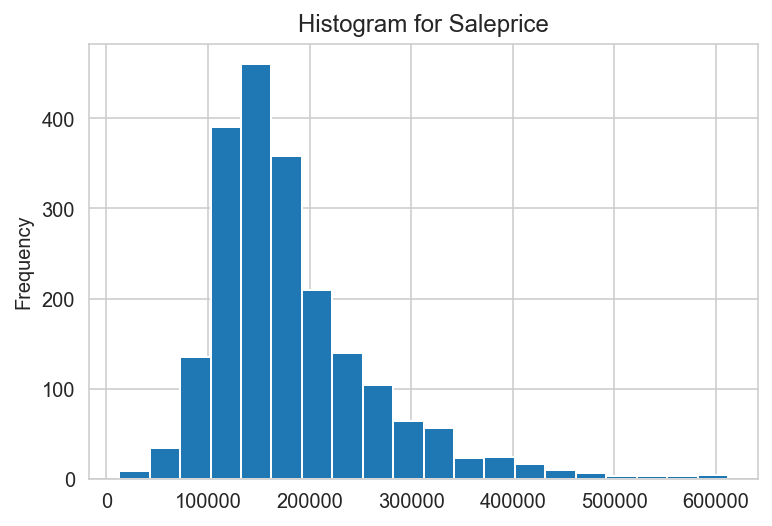

In [17]:
ames['saleprice'].plot.hist(bins=20, title='Histogram for Saleprice');

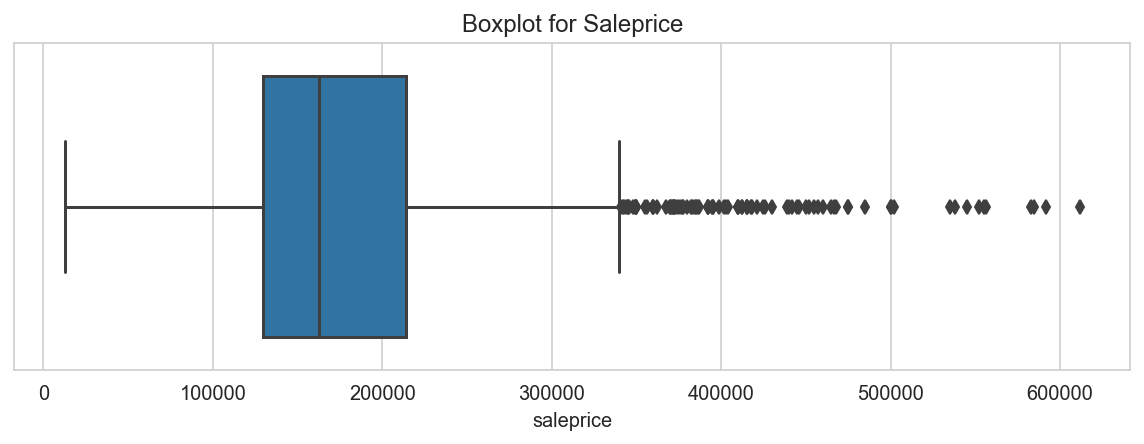

In [18]:
plt.figure(figsize=(10,3))
sns.boxplot(ames['saleprice']).set_title('Boxplot for Saleprice');

In [19]:
amesCleaned = amesXScaled.copy()
amesCleaned['saleprice'] = ames['saleprice']

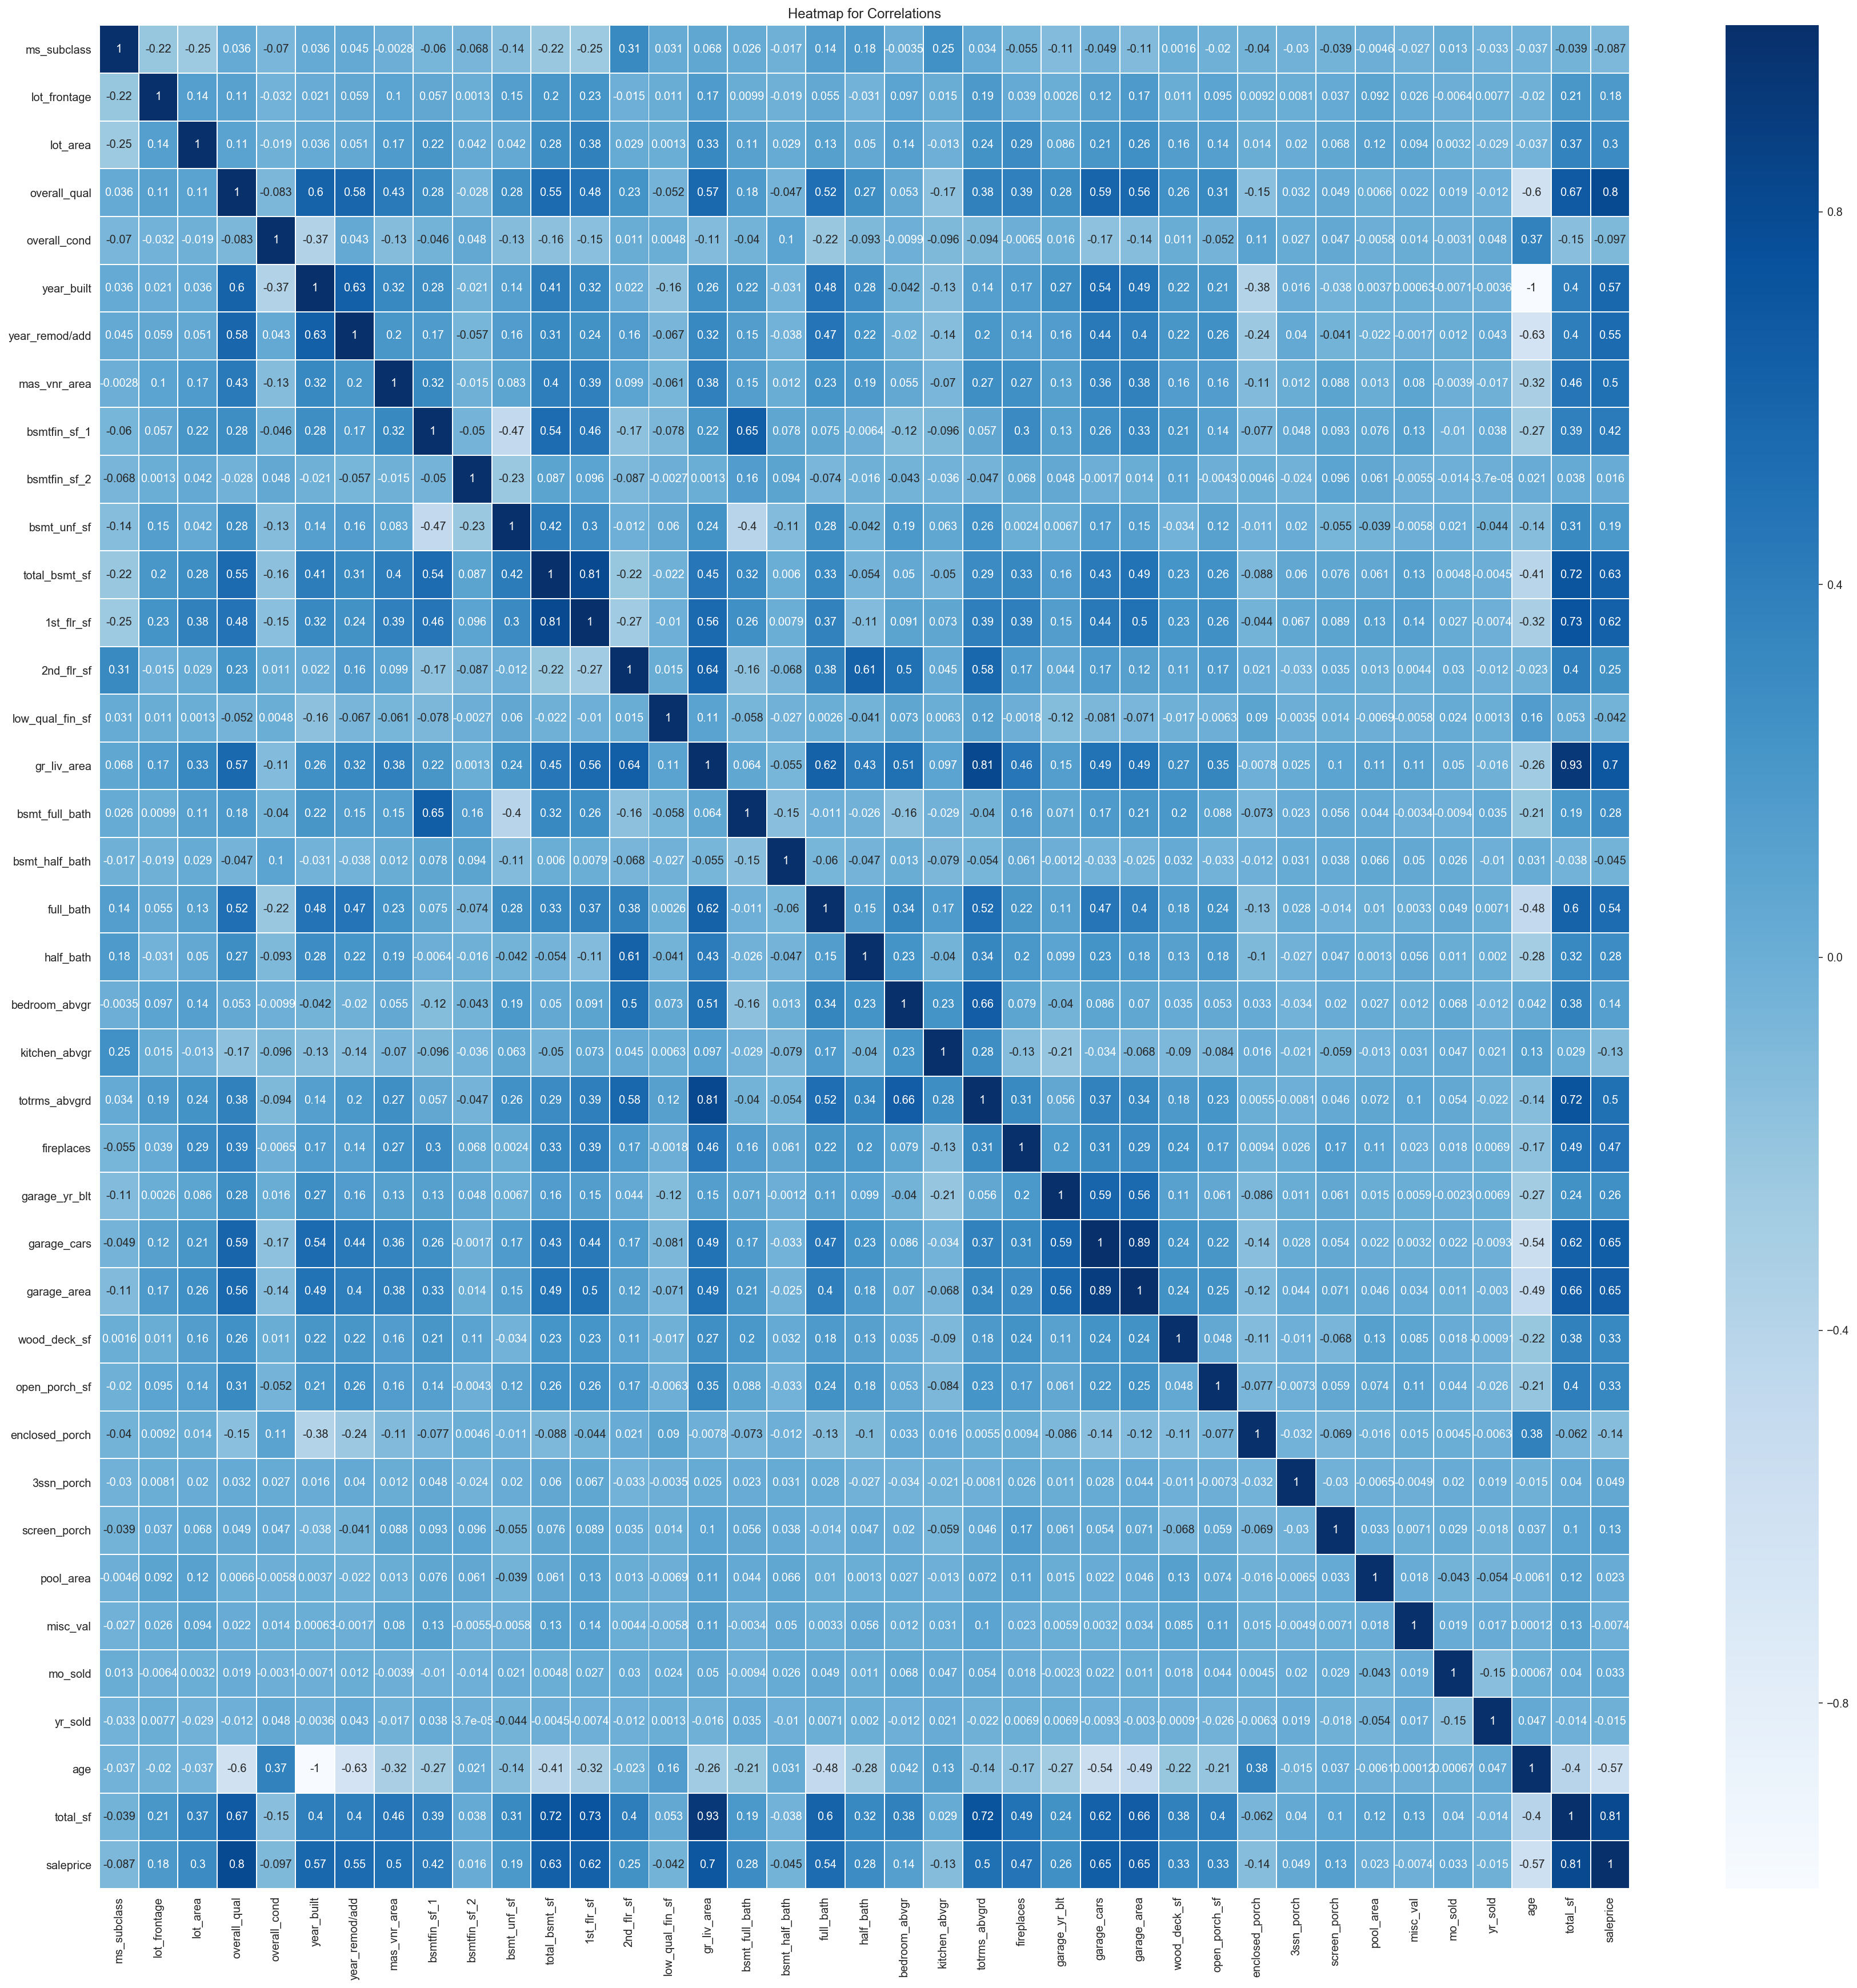

In [20]:
plt.figure(figsize = (30,30))
ax = sns.heatmap(amesCleaned.corr(),xticklabels=True, yticklabels=True, annot=True,linewidths=.5, cmap="Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Heatmap for Correlations');

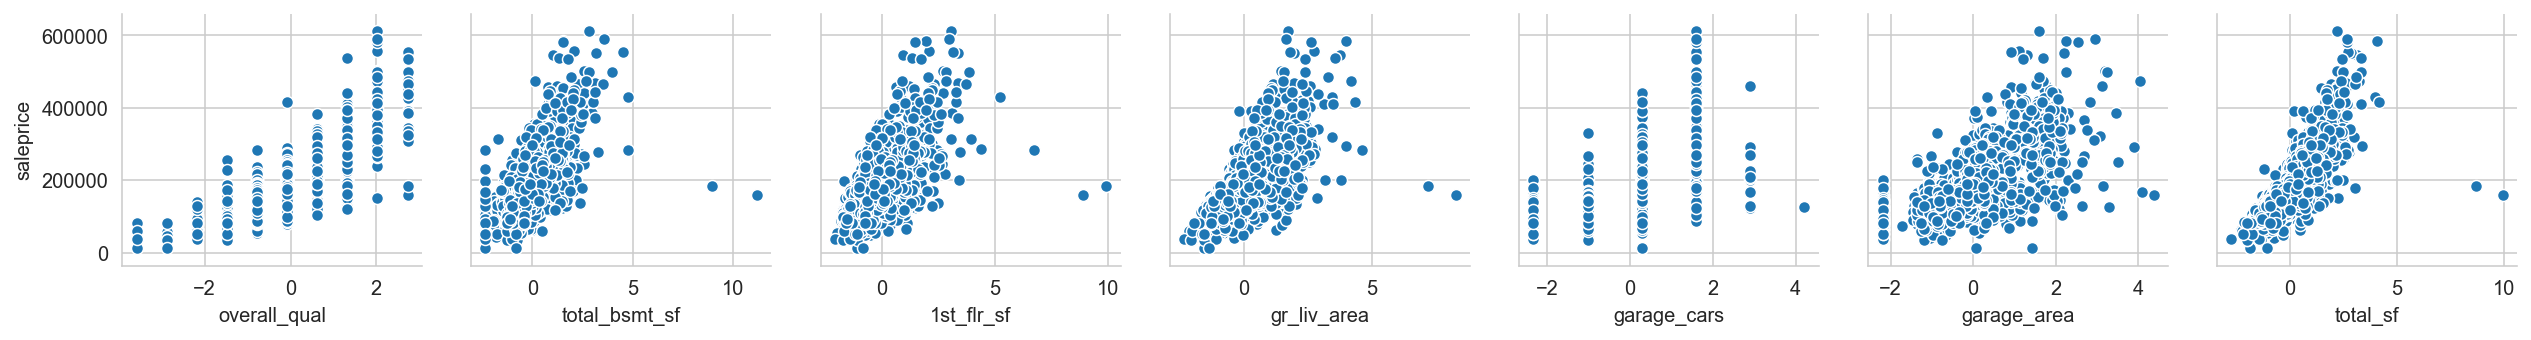

In [21]:
# Identify variables with highest correlations with 'saleprice' > abs(0.6)
sns.pairplot(amesCleaned,y_vars=['saleprice'],x_vars=['overall_qual', 'total_bsmt_sf', '1st_flr_sf','gr_liv_area', 
                                               'garage_cars','garage_area','total_sf']);

**Remove Outliers**

In [22]:
amesDroppedOutliers = ames.copy()
amesDroppedOutliers = amesDroppedOutliers[amesXScaled['total_sf']<5]
amesXScaled = amesXScaled[amesXScaled['total_sf']<5]
amesDroppedOutliers

id        pid  ms_subclass ms_zoning  lot_frontage  lot_area street  \
0      109  533352170           60        RL           0.0     13517   Pave   
1      544  531379050           60        RL          43.0     11492   Pave   
2      153  535304180           20        RL          68.0      7922   Pave   
3      318  916386060           60        RL          73.0      9802   Pave   
4      255  906425045           50        RL          82.0     14235   Pave   
...    ...        ...          ...       ...           ...       ...    ...   
2046  1587  921126030           20        RL          79.0     11449   Pave   
2047   785  905377130           30        RL           0.0     12342   Pave   
2048   916  909253010           50        RL          57.0      7558   Pave   
2049   639  535179160           20        RL          80.0     10400   Pave   
2050    10  527162130           60        RL          60.0      7500   Pave   

         alley lot_shape land_contour  ...  pool_qc     fence misc_feature  \
0     No_Alley       IR1          Lvl  ...  No_Pool  No_Fence         None   
1     No_Alley       IR1          Lvl  ...  No_Pool  No_Fence         None   
2     No_Alley       Reg          Lvl  ...  No_Pool  No_Fence         None   
3     No_Alley       Reg          Lvl  ...  No_Pool  No_Fence         None   
4     No_Alley       IR1          Lvl  ...  No_Pool  No_Fence         None   
...        ...       ...          ...  ...      ...       ...          ...   
2046  No_Alley       IR1          HLS  ...  No_Pool  No_Fence         None   
2047  No_Alley       IR1          Lvl  ...  No_Pool  No_Fence         None   
2048  No_Alley       Reg          Bnk  ...  No_Pool  No_Fence         None   
2049  No_Alley       Reg          Lvl  ...  No_Pool  No_Fence         None   
2050  No_Alley       Reg          Lvl  ...  No_Pool  No_Fence         None   

     misc_val mo_sold yr_sold sale_type saleprice  age  total_sf  
0           0       3    2010       WD     130500   34    4202.0  
1           0       4    2009       WD     220000   13    5790.0  
2           0       1    2010       WD     109000   57    3469.0  
3           0       4    2010       WD     174000    4    3772.0  
4           0       3    2010       WD     138500  110    4109.0  
...       ...     ...     ...       ...       ...  ...       ...  
2046        0       1    2008       WD     298751    1    6136.0  
2047        0       3    2009       WD      82500   69    3280.0  
2048        0       3    2009       WD     177000   81    5064.0  
2049        0      11    2009       WD     144000   53    4083.0  
2050        0       6    2010       WD     189000   11    5244.0  

[2049 rows x 83 columns]

Since 'total_sf' has much higher correlation to the sale price (0.81) as compared to the individual area sf, we choose only the 'total_sf' to represent the total size of the house.

Since 'age' of house has similar correlation as 'year_built' (0.57) to the sale price, 'age' is dropped.

In [23]:
toDrop = ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf','1st_flr_sf','2nd_flr_sf',
          'low_qual_fin_sf','wood_deck_sf','open_porch_sf','garage_area','garage_cars','gr_liv_area','age']

In [24]:
amesXScaled.drop(columns=toDrop,axis=1,inplace=True)

In [25]:
amesXScaled.head()

ms_subclass  lot_frontage  lot_area  overall_qual  overall_cond  \
0     0.069866     -1.749041  0.512071     -0.078644      2.207728   
1     0.069866     -0.451094  0.211664      0.622656     -0.509102   
2    -0.864413      0.303526 -0.317944     -0.779944      1.302118   
3     0.069866      0.454450 -0.039047     -0.779944     -0.509102   
4    -0.163704      0.726113  0.618586     -0.078644      2.207728   

   year_built  year_remod/add  mas_vnr_area  bsmt_full_bath  bsmt_half_bath  \
0    0.142227        0.989479      1.092329       -0.817494       -0.251994   
1    0.805126        0.609090      0.191491        1.096524       -0.251994   
2   -0.620106        1.084576     -0.565901        1.096524       -0.251994   
3    1.136575        1.084576     -0.565901       -0.817494       -0.251994   
4   -2.376787        0.418896     -0.565901       -0.817494       -0.251994   

   ...  fireplaces  garage_yr_blt  enclosed_porch  3ssn_porch  screen_porch  \
0  ...   -0.925701       0.236274       -0.377264   -0.102738     -0.287856   
1  ...    0.640811       0.282528       -0.377264   -0.102738     -0.287856   
2  ...   -0.925701       0.185616       -0.377264   -0.102738     -0.287856   
3  ...   -0.925701       0.304553       -0.377264   -0.102738     -0.287856   
4  ...   -0.925701       0.194426       -0.377264   -0.102738     -0.287856   

   pool_area  misc_val   mo_sold   yr_sold  total_sf  
0   -0.06348 -0.089968 -1.173402  1.695731 -0.318677  
1   -0.06348 -0.089968 -0.808979  0.933358  0.760424  
2   -0.06348 -0.089968 -1.902247  1.695731 -0.816776  
3   -0.06348 -0.089968 -0.808979  1.695731 -0.610877  
4   -0.06348 -0.089968 -1.173402  1.695731 -0.381874  

[5 rows x 25 columns]

In [26]:
amesXScaled.columns

Index(['ms_subclass', 'lot_frontage', 'lot_area', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area',
       'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath',
       'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces',
       'garage_yr_blt', 'enclosed_porch', '3ssn_porch', 'screen_porch',
       'pool_area', 'misc_val', 'mo_sold', 'yr_sold', 'total_sf'],
      dtype='object')

In [27]:
amesCleaned2 = amesXScaled.copy()
amesCleaned2['saleprice'] = ames['saleprice']

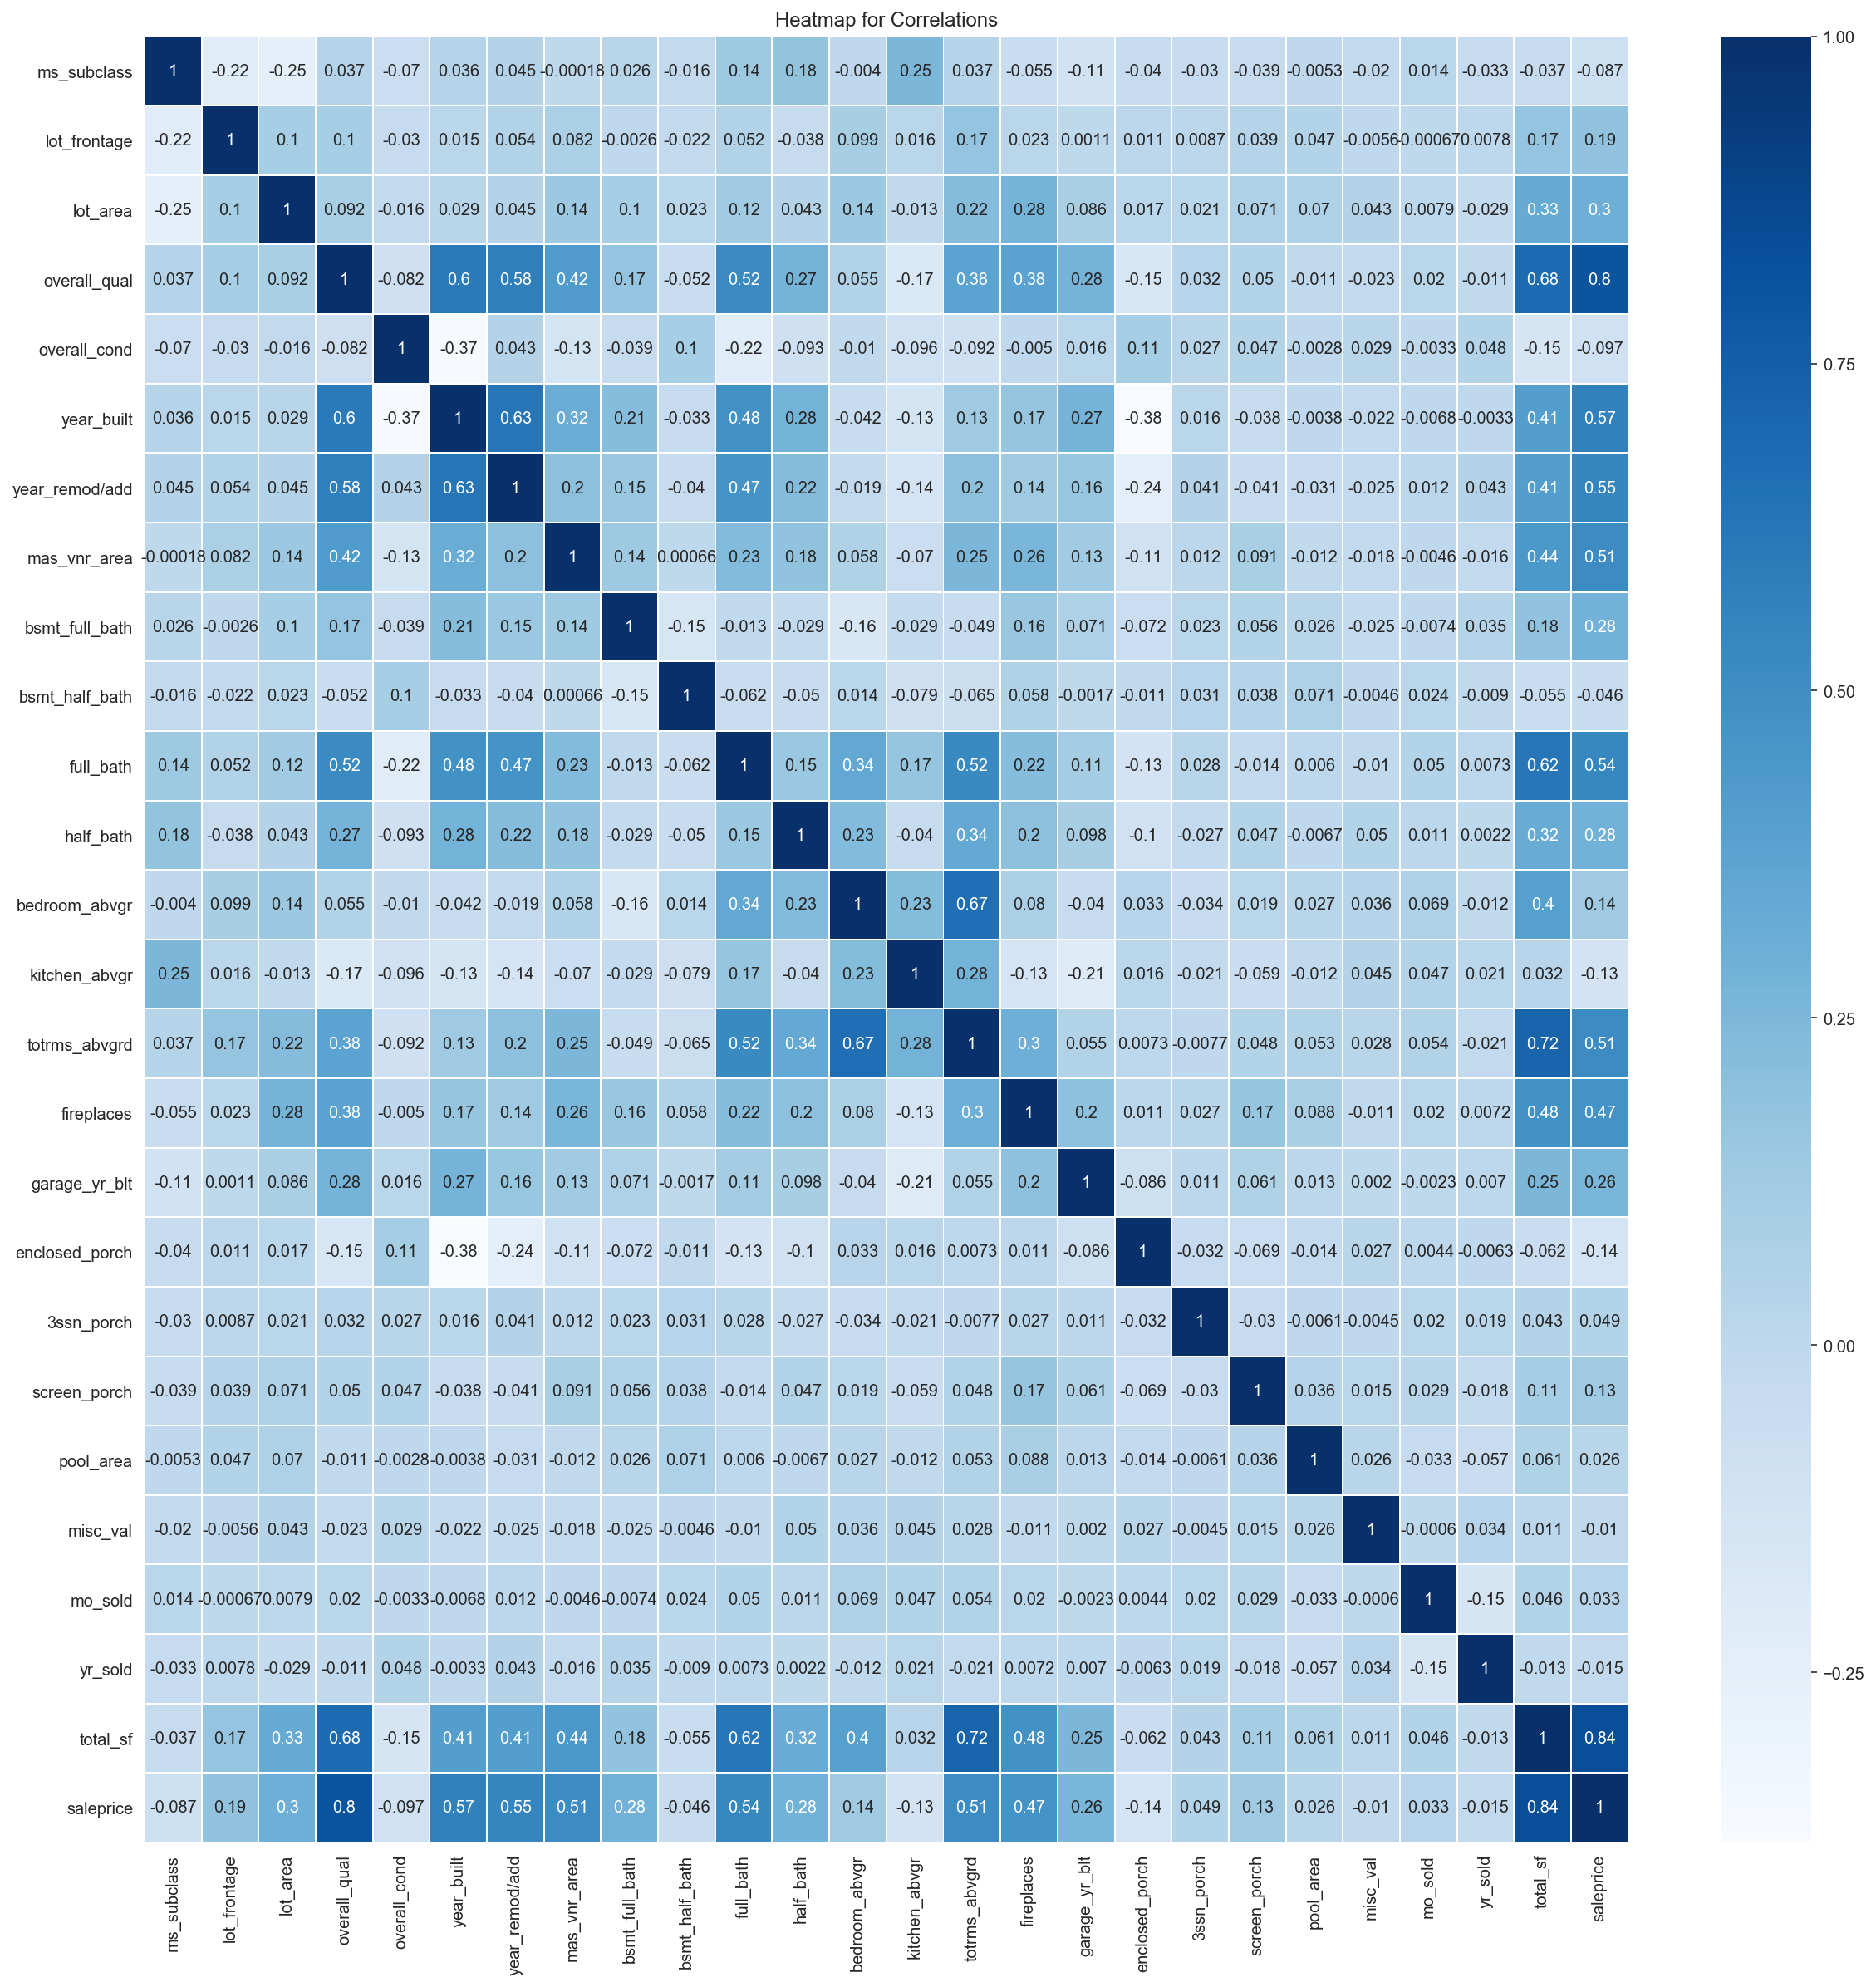

In [28]:
plt.figure(figsize = (20,20))
ax = sns.heatmap(amesCleaned2.corr(),xticklabels=True, yticklabels=True, annot=True,linewidths=.5, cmap="Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Heatmap for Correlations');

Remove features with very low correlations with target 'saleprice' (< abs(0.3))

In [29]:
toDrop2 = ['ms_subclass', 'lot_frontage', 'overall_cond', 'bsmt_full_bath','bsmt_half_bath','half_bath',
          'bedroom_abvgr','kitchen_abvgr','garage_yr_blt','enclosed_porch','3ssn_porch','screen_porch',
           'pool_area','misc_val','mo_sold','yr_sold']

In [30]:
amesXScaled.drop(columns=toDrop2,axis=1,inplace=True)

In [31]:
amesXScaled.head()

lot_area  overall_qual  year_built  year_remod/add  mas_vnr_area  \
0  0.512071     -0.078644    0.142227        0.989479      1.092329   
1  0.211664      0.622656    0.805126        0.609090      0.191491   
2 -0.317944     -0.779944   -0.620106        1.084576     -0.565901   
3 -0.039047     -0.779944    1.136575        1.084576     -0.565901   
4  0.618586     -0.078644   -2.376787        0.418896     -0.565901   

   full_bath  totrms_abvgrd  fireplaces  total_sf  
0   0.769779      -0.279441   -0.925701 -0.318677  
1   0.769779       1.002738    0.640811  0.760424  
2  -1.051232      -0.920531   -0.925701 -0.816776  
3   0.769779       0.361648   -0.925701 -0.610877  
4   0.769779      -0.279441   -0.925701 -0.381874

In [32]:
amesXScaled.shape

(2049, 9)

In [33]:
amesXScaled.columns

Index(['lot_area', 'overall_qual', 'year_built', 'year_remod/add',
       'mas_vnr_area', 'full_bath', 'totrms_abvgrd', 'fireplaces', 'total_sf'],
      dtype='object')

In [34]:
amesCleaned3 = amesXScaled.copy()
amesCleaned3['saleprice'] = ames['saleprice']

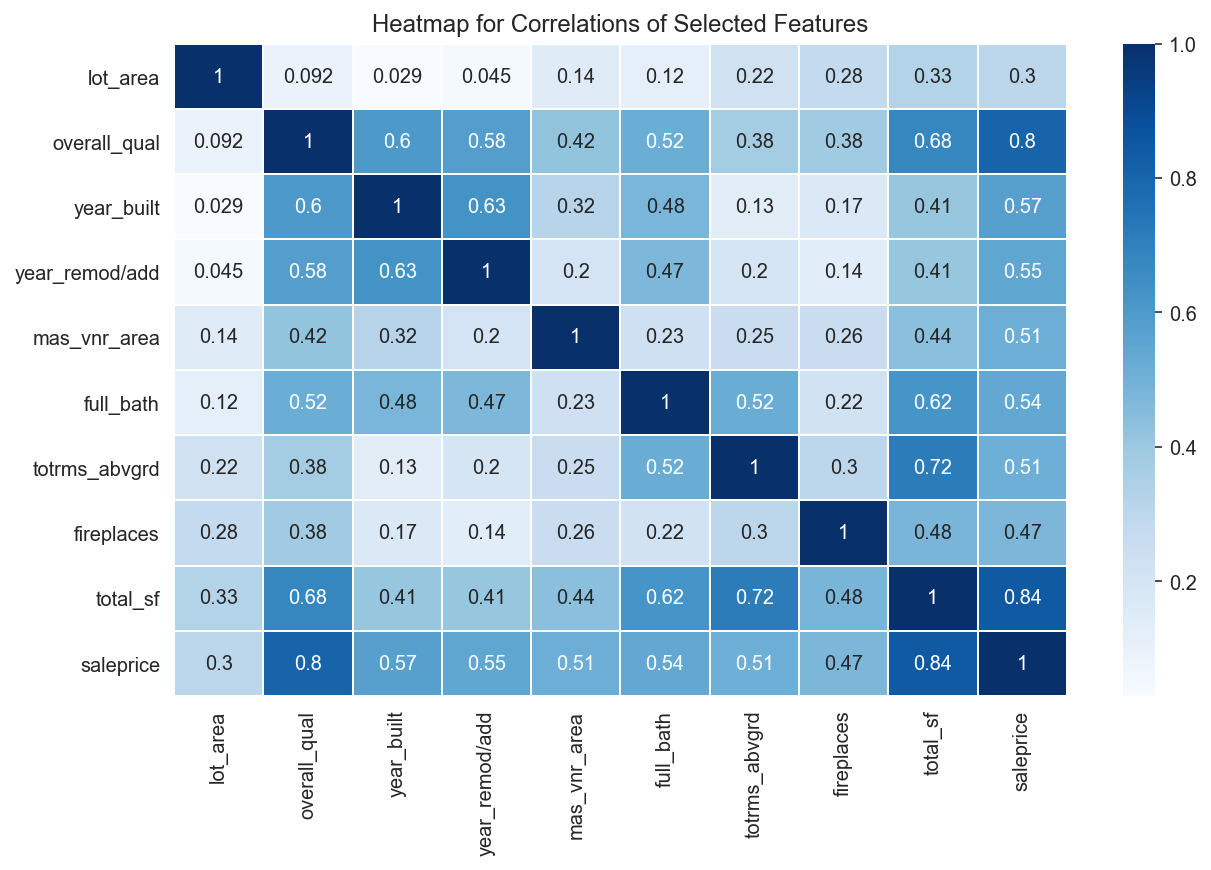

In [35]:
plt.figure(figsize = (10,6))
ax = sns.heatmap(amesCleaned3.corr(),xticklabels=True, yticklabels=True, annot=True,linewidths=.5, cmap="Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Heatmap for Correlations of Selected Features');

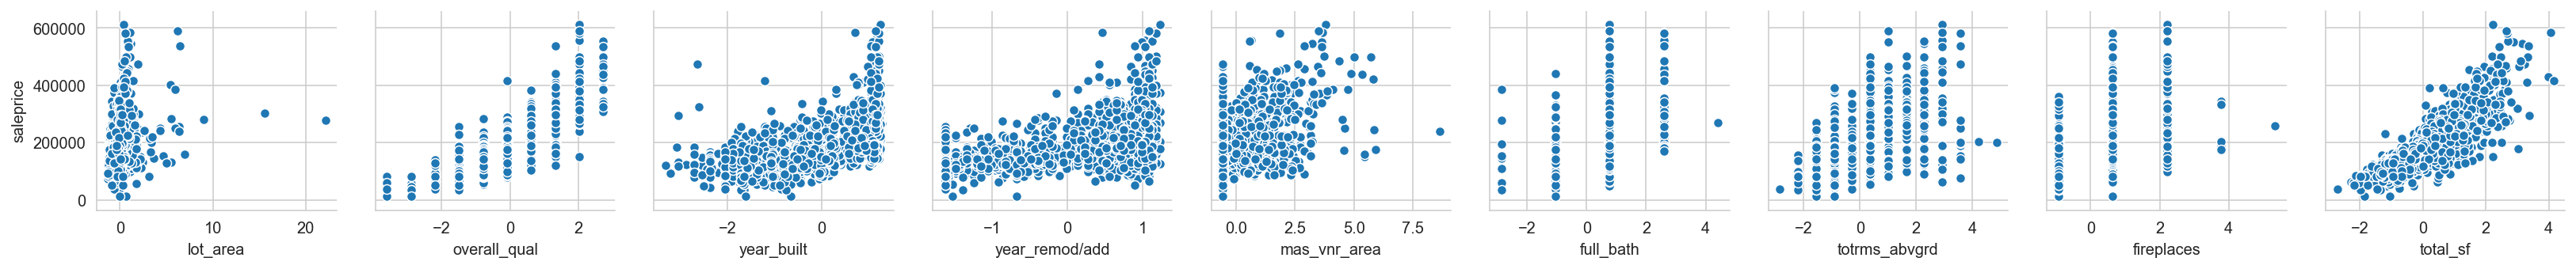

In [36]:
sns.pairplot(amesCleaned3,y_vars=['saleprice'],x_vars=amesXScaled.columns);

**Removing outliers based on selected features**
- By z-score > 5, similar to how outliers from 'total_sf' was removed earlier

In [37]:
amesDroppedOutliers = amesDroppedOutliers[amesXScaled['lot_area']<5]
amesXScaled = amesXScaled[amesXScaled['lot_area']<5]
amesDroppedOutliers = amesDroppedOutliers[amesXScaled['mas_vnr_area']<5]
amesXScaled = amesXScaled[amesXScaled['mas_vnr_area']<5]
amesDroppedOutliers

id        pid  ms_subclass ms_zoning  lot_frontage  lot_area street  \
0      109  533352170           60        RL           0.0     13517   Pave   
1      544  531379050           60        RL          43.0     11492   Pave   
2      153  535304180           20        RL          68.0      7922   Pave   
3      318  916386060           60        RL          73.0      9802   Pave   
4      255  906425045           50        RL          82.0     14235   Pave   
...    ...        ...          ...       ...           ...       ...    ...   
2046  1587  921126030           20        RL          79.0     11449   Pave   
2047   785  905377130           30        RL           0.0     12342   Pave   
2048   916  909253010           50        RL          57.0      7558   Pave   
2049   639  535179160           20        RL          80.0     10400   Pave   
2050    10  527162130           60        RL          60.0      7500   Pave   

         alley lot_shape land_contour  ...  pool_qc     fence misc_feature  \
0     No_Alley       IR1          Lvl  ...  No_Pool  No_Fence         None   
1     No_Alley       IR1          Lvl  ...  No_Pool  No_Fence         None   
2     No_Alley       Reg          Lvl  ...  No_Pool  No_Fence         None   
3     No_Alley       Reg          Lvl  ...  No_Pool  No_Fence         None   
4     No_Alley       IR1          Lvl  ...  No_Pool  No_Fence         None   
...        ...       ...          ...  ...      ...       ...          ...   
2046  No_Alley       IR1          HLS  ...  No_Pool  No_Fence         None   
2047  No_Alley       IR1          Lvl  ...  No_Pool  No_Fence         None   
2048  No_Alley       Reg          Bnk  ...  No_Pool  No_Fence         None   
2049  No_Alley       Reg          Lvl  ...  No_Pool  No_Fence         None   
2050  No_Alley       Reg          Lvl  ...  No_Pool  No_Fence         None   

     misc_val mo_sold yr_sold sale_type saleprice  age  total_sf  
0           0       3    2010       WD     130500   34    4202.0  
1           0       4    2009       WD     220000   13    5790.0  
2           0       1    2010       WD     109000   57    3469.0  
3           0       4    2010       WD     174000    4    3772.0  
4           0       3    2010       WD     138500  110    4109.0  
...       ...     ...     ...       ...       ...  ...       ...  
2046        0       1    2008       WD     298751    1    6136.0  
2047        0       3    2009       WD      82500   69    3280.0  
2048        0       3    2009       WD     177000   81    5064.0  
2049        0      11    2009       WD     144000   53    4083.0  
2050        0       6    2010       WD     189000   11    5244.0  

[2028 rows x 83 columns]

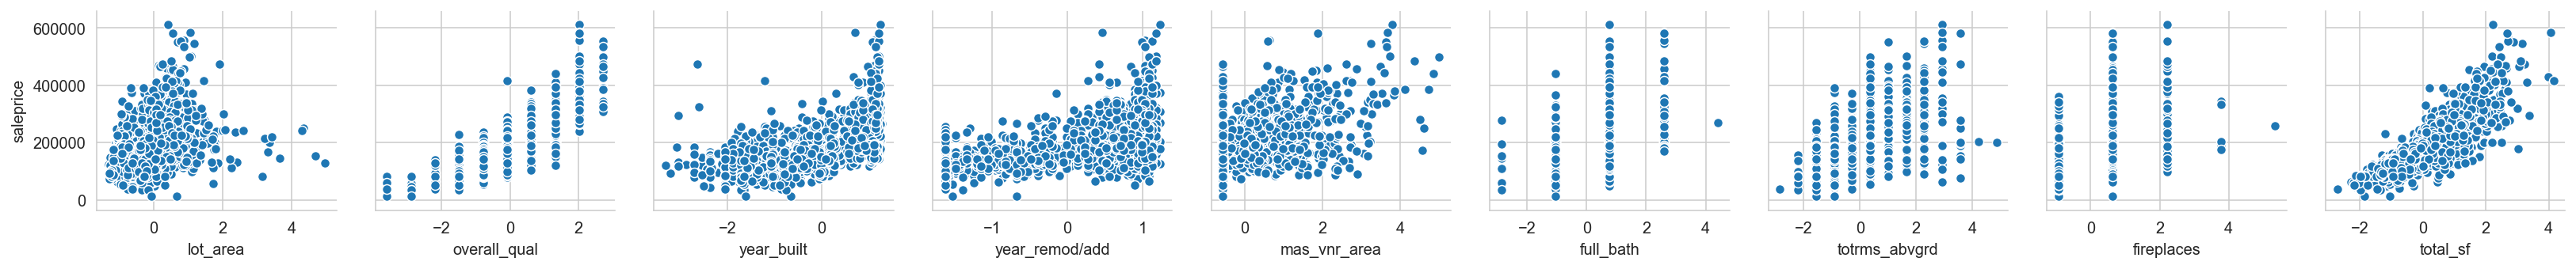

In [38]:
amesCleaned4 = amesXScaled.copy()
amesCleaned4['saleprice'] = ames['saleprice']
sns.pairplot(amesCleaned4,y_vars=['saleprice'],x_vars=amesXScaled.columns);

**Use VIF to check for multi-collinearity problems in the data**

In [39]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(amesXScaled.values, i) for i in range(amesXScaled.shape[1])]
vif["features"] = amesXScaled.columns;

In [40]:
vifFeaturesDf = vif.round(1).sort_values(by='VIF Factor',ascending=True)
vifFeaturesDf = vifFeaturesDf[vifFeaturesDf['VIF Factor'] < 5.0]
vifFeaturesDf

VIF Factor        features
0         1.3        lot_area
4         1.3    mas_vnr_area
7         1.4      fireplaces
3         2.0  year_remod/add
5         2.0       full_bath
2         2.1      year_built
6         2.3   totrms_abvgrd
1         2.9    overall_qual
8         4.6        total_sf

In [41]:
featuresVIF = list(vifFeaturesDf['features'])
xVIF = amesXScaled[featuresVIF]
xVIF.head()

lot_area  mas_vnr_area  fireplaces  year_remod/add  full_bath  year_built  \
0  0.512071      1.092329   -0.925701        0.989479   0.769779    0.142227   
1  0.211664      0.191491    0.640811        0.609090   0.769779    0.805126   
2 -0.317944     -0.565901   -0.925701        1.084576  -1.051232   -0.620106   
3 -0.039047     -0.565901   -0.925701        1.084576   0.769779    1.136575   
4  0.618586     -0.565901   -0.925701        0.418896   0.769779   -2.376787   

   totrms_abvgrd  overall_qual  total_sf  
0      -0.279441     -0.078644 -0.318677  
1       1.002738      0.622656  0.760424  
2      -0.920531     -0.779944 -0.816776  
3       0.361648     -0.779944 -0.610877  
4      -0.279441     -0.078644 -0.381874

In [42]:
amesY = amesCleaned4['saleprice']

### Model 3

In [43]:
def linearRegression(x, y):
    model = sm.OLS(y, x)
    model = model.fit()
    return (model)

In [44]:
model3 = linearRegression(sm.add_constant(xVIF.values), amesY)
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     1299.
Date:                Thu, 19 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:27:19   Log-Likelihood:                -23767.
No. Observations:                2028   AIC:                         4.755e+04
Df Residuals:                    2018   BIC:                         4.761e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.825e+05    666.040    273.974      0.000    1.81e+05    1.84e+05
x1          1.212e+04   1231.128      9.846      0.000    9706.909    1.45e+04
x2          8705.4451    850.350     10.237      0.000    7037.790    1.04e+04
x3          3895.6349    784.743      4.964      0.000    2356.643    5434.627
x4          7754.1494    924.195      8.390      0.000    5941.673    9566.625
x5         -4774.9504    949.710     -5.028      0.000   -6637.464   -2912.437
x6          8114.6063    964.272      8.415      0.000    6223.533       1e+04
x7         -3644.2662   1031.877     -3.532      0.000   -5667.922   -1620.610
x8          2.495e+04   1131.850     22.041      0.000    2.27e+04    2.72e+04
x9          4.147e+04   1511.912     27.428      0.000    3.85e+04    4.44e+04
==============================================================================
Omnibus:                      597.531   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4174.488
Skew:                           1.200   Prob(JB):                         0.00
Kurtosis:                       9.606   Cond. No.                         5.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 3 Validation

**Cross Validation**

In [45]:
lr = LinearRegression()
scores = cross_val_score(lr, xVIF.values, amesY, cv=5)
print(scores.mean())
print(scores.std())
print(scores)

0.8511342034946697
0.011942632107203793
[0.84774888 0.86223985 0.84392629 0.86709915 0.83465685]


**Train Test Split**

In [46]:
model3_x80 = xVIF.values
model3_xTrain80, model3_xTest80, model3_yTrain80, model3_yTest80 = train_test_split(model3_x80, amesY, 
                                                                                    train_size=0.8,random_state=42)
model3_80 = LinearRegression().fit(model3_xTrain80,model3_yTrain80)
print(model3_80.coef_)
print(model3_80.intercept_)

[12306.30853514  8040.17731538  4456.70261646  7817.65326811
 -4486.32569971  7469.61662251 -3956.91631857 24376.16710201
 41512.80827669]
182365.7399119166


In [47]:
model3_80.score(model3_xTrain80,model3_yTrain80)

0.8518129695244065

In [48]:
model3_80.score(model3_xTest80,model3_yTest80)

0.8540580100707384

In [49]:
rmse = np.sqrt(mean_squared_error(model3_yTest80,model3_80.predict(model3_xTest80)))
print(rmse)

32250.063223647485


**Plot predicted values for saleprice vs actual values in TTS test set**

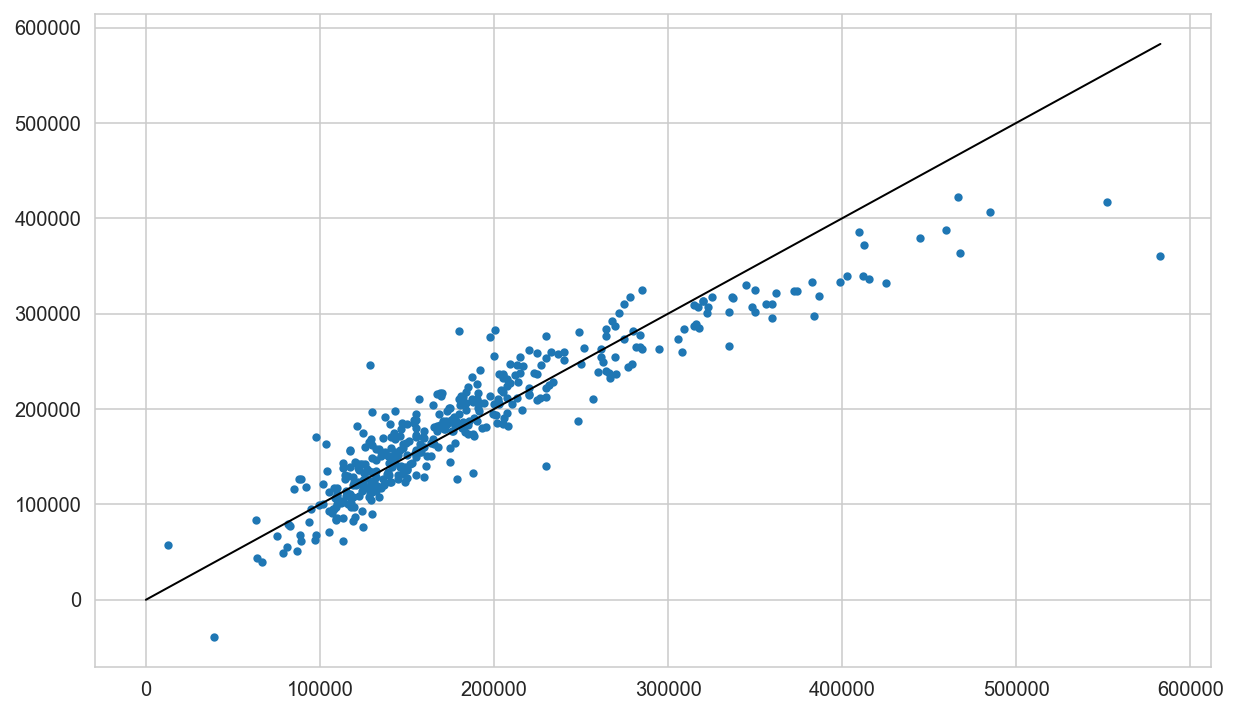

In [50]:
plt.figure(figsize=(10,6))
plt.scatter(model3_yTest80, model3_80.predict(model3_xTest80),s=10)
plt.plot([0, np.max(model3_yTest80)], [0, np.max(model3_yTest80)],c='k',linewidth=1);

### Model 3 Prediction on Kaggle Test Set

In [51]:
testSet = pd.read_csv('../datasets/test.csv')
testSet.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   
2  2414  528218130           60        RL          58.0     17104   Pave   
3  1989  902207150           30        RM          60.0      8520   Pave   
4   625  535105100           20        RL           NaN      9500   Pave   

  Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch Pool Area Pool QC  \
0  Grvl       Reg          Lvl  ...          0            0         0     NaN   
1   NaN       IR1          Lvl  ...          0            0         0     NaN   
2   NaN       IR1          Lvl  ...          0            0         0     NaN   
3   NaN       Reg          Lvl  ...          0            0         0     NaN   
4   NaN       IR1          Lvl  ...          0          185         0     NaN   

  Fence Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  
0   NaN          NaN        0       4     2006        WD   
1   NaN          NaN        0       8     2006        WD   
2   NaN          NaN        0       9     2006        New  
3   NaN          NaN        0       7     2007        WD   
4   NaN          NaN        0       7     2009        WD   

[5 rows x 80 columns]

**Clean and prepare test data in the same format as the train dataset**

In [52]:
testSet.isnull().sum()[testSet.isnull().sum()>0]

Lot Frontage      160
Alley             821
Mas Vnr Type        1
Mas Vnr Area        1
Bsmt Qual          25
Bsmt Cond          25
Bsmt Exposure      25
BsmtFin Type 1     25
BsmtFin Type 2     25
Electrical          1
Fireplace Qu      422
Garage Type        44
Garage Yr Blt      45
Garage Finish      45
Garage Qual        45
Garage Cond        45
Pool QC           875
Fence             707
Misc Feature      838
dtype: int64

In [53]:
testSet = renameCols(testSet)
testSet = replaceNulls(testSet)

In [54]:
testSet.isnull().sum()[testSet.isnull().sum()>0]

electrical    1
dtype: int64

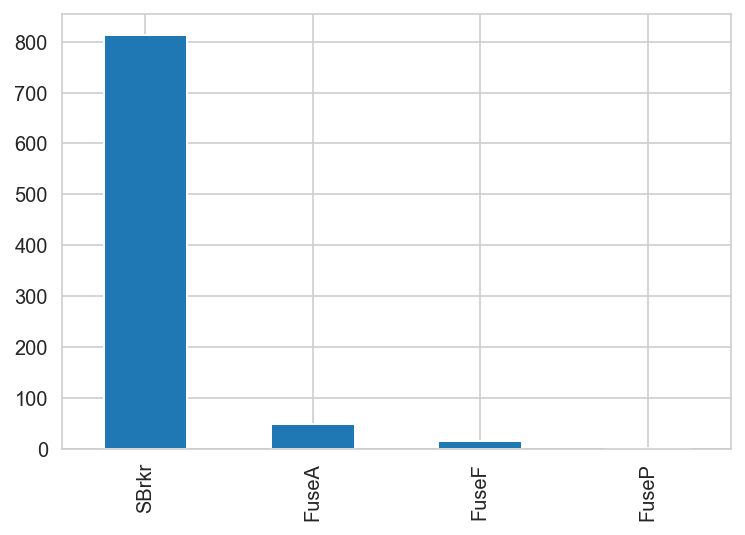

In [55]:
testSet['electrical'].value_counts().plot.bar()

Replace null values with mode (most frequent category)

In [56]:
testSet['electrical'].fillna('SBrkr',inplace=True)

In [57]:
testSetX = filterXCols(testSet)

In [58]:
testSetX['age'] = testSetX['yr_sold'] - testSetX['year_built']
testSetX['total_sf'] = (testSetX['total_bsmt_sf'] + testSetX['1st_flr_sf'] + testSetX['2nd_flr_sf'] + 
                        testSetX['low_qual_fin_sf'] + testSetX['wood_deck_sf'] + testSetX['open_porch_sf'] + 
                        testSetX['garage_area'] + testSetX['gr_liv_area'])

In [59]:
testSetXScaled = pd.DataFrame(scaler.transform(testSetX[colsToNorm]),columns=colsToNorm)
testSetXScaled.head()

ms_subclass  lot_frontage  lot_area  overall_qual  overall_cond  \
0     3.106271      0.333711 -0.136957     -0.078644      2.207728   
1     0.770575     -1.749041 -0.059816     -0.779944     -1.414712   
2     0.069866      0.001678  1.044200      0.622656     -0.509102   
3    -0.630843      0.062047 -0.229231     -0.779944      0.396508   
4    -0.864413     -1.749041 -0.083848     -0.078644     -0.509102   

   year_built  year_remod/add  mas_vnr_area  bsmtfin_sf_1  bsmtfin_sf_2  ...  \
0   -2.045338       -1.625693     -0.565901     -0.958797     -0.290653  ...   
1    0.175372       -0.341881     -0.565901     -0.958797     -0.290653  ...   
2    1.136575        1.037027     -0.565901      0.242723     -0.290653  ...   
3   -1.614454        1.037027     -0.565901     -0.958797     -0.290653  ...   
4   -0.288657       -1.007562      0.851340      0.362007     -0.290653  ...   

   open_porch_sf  enclosed_porch  3ssn_porch  screen_porch  pool_area  \
0       0.186468        1.494690   -0.102738     -0.287856   -0.06348   
1      -0.712665       -0.377264   -0.102738     -0.287856   -0.06348   
2      -0.353012       -0.377264   -0.102738     -0.287856   -0.06348   
3      -0.712665        2.698089   -0.102738     -0.287856   -0.06348   
4       0.426237       -0.377264   -0.102738      2.937376   -0.06348   

   misc_val   mo_sold   yr_sold       age  total_sf  
0 -0.089968 -0.808979 -1.353760  1.984300  0.479097  
1 -0.089968  0.648711 -1.353760 -0.233971  1.345504  
2 -0.089968  1.013134 -1.353760 -1.194119 -0.322754  
3 -0.089968  0.284289 -0.591387  1.586998 -0.874537  
4 -0.089968  0.284289  0.933358  0.328874  0.068658  

[5 rows x 38 columns]

In [60]:
model3FeaturesOLS = xVIF.columns

In [61]:
testSetXScaled = testSetXScaled[model3FeaturesOLS]

In [62]:
testSetXScaled.head()

lot_area  mas_vnr_area  fireplaces  year_remod/add  full_bath  year_built  \
0 -0.136957     -0.565901   -0.925701       -1.625693   0.769779   -2.045338   
1 -0.059816     -0.565901   -0.925701       -0.341881   0.769779    0.175372   
2  1.044200     -0.565901    0.640811        1.037027   0.769779    1.136575   
3 -0.229231     -0.565901   -0.925701        1.037027  -1.051232   -1.614454   
4 -0.083848      0.851340    2.207324       -1.007562  -1.051232   -0.288657   

   totrms_abvgrd  overall_qual  total_sf  
0       1.643827     -0.078644  0.479097  
1       2.284917     -0.779944  1.345504  
2       0.361648      0.622656 -0.322754  
3      -0.920531     -0.779944 -0.874537  
4      -0.279441     -0.078644  0.068658

In [63]:
yhat3 = model3.predict(sm.add_constant(testSetXScaled.values))

In [64]:
model3Pred = pd.DataFrame()
model3Pred['ID'] = testSet['id']
model3Pred['SalePrice'] = yhat3

In [65]:
model3Pred.shape

(879, 2)

In [66]:
model3Pred = model3Pred.set_index('ID');

In [67]:
model3Pred.to_csv('../predictions/model3Pred.csv')

### Model 4

**Regularisation based on selected features**

In [68]:
r_alphas = np.logspace(0, 5, 200)
ridge = RidgeCV(alphas=r_alphas).fit(xVIF.values, amesY)
bestRidgeAlpha = ridge.alpha_
ridgeOptimal = RidgeCV(alphas=[bestRidgeAlpha],cv=5).fit(xVIF.values, amesY)
ridgeOptimal.score(xVIF.values, amesY)

0.8527848386183963

In [69]:
bestRidgeAlpha

3.78346261713193

In [70]:
ridgeOptimal.coef_

array([12122.71336426,  8741.18497102,  3951.323816  ,  7766.30696212,
       -4691.77424831,  8130.43014102, -3504.73818181, 24946.40053827,
       41169.6833024 ])

In [71]:
lasso = LassoCV(n_alphas=100,cv=5).fit(xVIF.values, amesY)
bestLassoAlpha = lasso.alpha_
lassoOptimal = LassoCV(alphas=[bestLassoAlpha],cv=5).fit(xVIF.values, amesY)
lassoOptimal.score(xVIF.values, amesY)

0.8527798445287453

In [72]:
elasticNet = ElasticNetCV(n_alphas=100,cv=5,l1_ratio=[.1, .5, .7, .9, .95, .99, 1]).fit(xVIF.values, amesY)
bestElasticAlpha = elasticNet.alpha_
bestElasticRatio = elasticNet.l1_ratio_
elasticOptimal = ElasticNetCV(alphas=[bestElasticAlpha],l1_ratio=bestElasticRatio, 
                              cv=5).fit(xVIF.values, amesY)
elasticOptimal.score(xVIF.values, amesY)

0.8527798445287453

Ridge model was selected as it gives the best R2 score.

In [73]:
model4 = Ridge(alpha=bestRidgeAlpha)

### Model 4 Validation

**Train Test Split**

In [74]:
model4_x80 = xVIF.values
model4_xTrain80, model4_xTest80, model4_yTrain80, model4_yTest80 = train_test_split(model4_x80, amesY, 
                                                                                    train_size=0.8,random_state=42)

In [75]:
model4_80 = model4.fit(model4_xTrain80,model4_yTrain80)
print(model4_80.coef_)
print(model4_80.intercept_)

[12310.93274055  8085.95063815  4525.7069094   7829.65137747
 -4383.25110274  7490.43751507 -3784.81485924 24380.13587807
 41132.11396308]
182361.14366170068


In [76]:
model4_80.score(model4_xTrain80,model4_yTrain80)

0.8518065831948429

In [77]:
model4_80.score(model4_xTest80,model4_yTest80)

0.8539903234521689

In [78]:
rmse = np.sqrt(mean_squared_error(model4_yTest80,model4_80.predict(model4_xTest80)))
print(rmse)

32257.54100535302


In [79]:
model4.fit(xVIF.values, amesY)

Ridge(alpha=3.78346261713193, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

### Model 4 Prediction on Kaggle Test Set

In [80]:
yhat4 = model4.predict(testSetXScaled.values)

In [81]:
model4Pred = pd.DataFrame()
model4Pred['ID'] = testSet['id']
model4Pred['SalePrice'] = yhat4

In [82]:
model4Pred.shape

(879, 2)

In [83]:
model4Pred = model4Pred.set_index('ID');

In [84]:
model4Pred.to_csv('../predictions/model4Pred.csv')

### Categorical Variables

In [85]:
numeric = ['int64','float64','uint8']
colsCategory = [x for x in amesX.columns if amesX[x].dtype not in numeric]
amesCat = amesDroppedOutliers[colsCategory]
amesCat.head()

ms_zoning street     alley lot_shape land_contour utilities lot_config  \
0        RL   Pave  No_Alley       IR1          Lvl    AllPub    CulDSac   
1        RL   Pave  No_Alley       IR1          Lvl    AllPub    CulDSac   
2        RL   Pave  No_Alley       Reg          Lvl    AllPub     Inside   
3        RL   Pave  No_Alley       Reg          Lvl    AllPub     Inside   
4        RL   Pave  No_Alley       IR1          Lvl    AllPub     Inside   

  land_slope neighborhood condition_1  ...  fireplace_qu garage_type  \
0        Gtl       Sawyer        RRAe  ...  No_Fireplace      Attchd   
1        Gtl      SawyerW        Norm  ...            TA      Attchd   
2        Gtl        NAmes        Norm  ...  No_Fireplace      Detchd   
3        Gtl       Timber        Norm  ...  No_Fireplace     BuiltIn   
4        Gtl      SawyerW        Norm  ...  No_Fireplace      Detchd   

  garage_finish garage_qual garage_cond paved_drive  pool_qc     fence  \
0           RFn          TA          TA           Y  No_Pool  No_Fence   
1           RFn          TA          TA           Y  No_Pool  No_Fence   
2           Unf          TA          TA           Y  No_Pool  No_Fence   
3           Fin          TA          TA           Y  No_Pool  No_Fence   
4           Unf          TA          TA           N  No_Pool  No_Fence   

  misc_feature sale_type  
0         None       WD   
1         None       WD   
2         None       WD   
3         None       WD   
4         None       WD   

[5 rows x 42 columns]

In [86]:
amesCat['saleprice'] = ames['saleprice']
amesCat.head()

ms_zoning street     alley lot_shape land_contour utilities lot_config  \
0        RL   Pave  No_Alley       IR1          Lvl    AllPub    CulDSac   
1        RL   Pave  No_Alley       IR1          Lvl    AllPub    CulDSac   
2        RL   Pave  No_Alley       Reg          Lvl    AllPub     Inside   
3        RL   Pave  No_Alley       Reg          Lvl    AllPub     Inside   
4        RL   Pave  No_Alley       IR1          Lvl    AllPub     Inside   

  land_slope neighborhood condition_1  ... garage_type garage_finish  \
0        Gtl       Sawyer        RRAe  ...      Attchd           RFn   
1        Gtl      SawyerW        Norm  ...      Attchd           RFn   
2        Gtl        NAmes        Norm  ...      Detchd           Unf   
3        Gtl       Timber        Norm  ...     BuiltIn           Fin   
4        Gtl      SawyerW        Norm  ...      Detchd           Unf   

  garage_qual garage_cond paved_drive  pool_qc     fence misc_feature  \
0          TA          TA           Y  No_Pool  No_Fence         None   
1          TA          TA           Y  No_Pool  No_Fence         None   
2          TA          TA           Y  No_Pool  No_Fence         None   
3          TA          TA           Y  No_Pool  No_Fence         None   
4          TA          TA           N  No_Pool  No_Fence         None   

  sale_type saleprice  
0       WD     130500  
1       WD     220000  
2       WD     109000  
3       WD     174000  
4       WD     138500  

[5 rows x 43 columns]

In [87]:
amesCat.shape

(2028, 43)

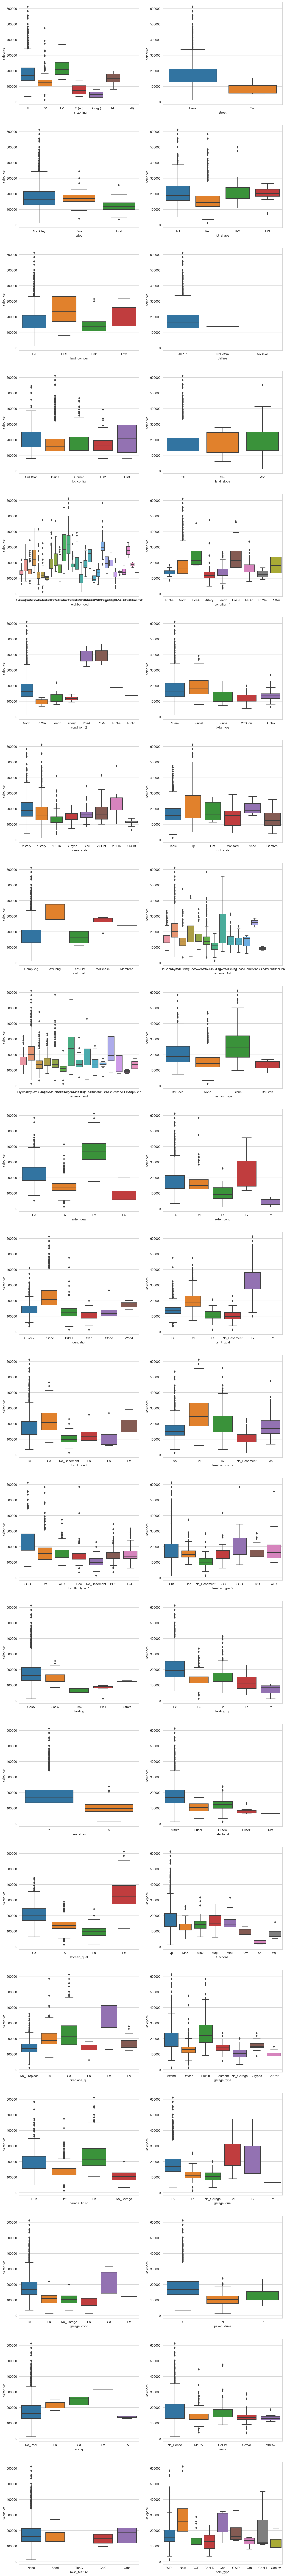

In [88]:
fig, axes = plt.subplots(ncols=2, nrows=21,figsize=(15,150))
axes = axes.flatten()

for axes, col in zip(axes, amesCat.columns[:-1]):
    sns.boxplot(x=col, y='saleprice', ax=axes, data=amesCat)

**ANOVA Test for correlation of categorical features with target 'saleprice'**
- Null hypothesis: category is not correlated with target

In [89]:
from scipy import stats

In [90]:
target = amesCat['saleprice']
amesCatAnova = amesCat.drop('saleprice',axis=1)

In [91]:
anovaResults = pd.DataFrame()
for colName in amesCatAnova.columns:
    inputsToAnova = [target[idxs] for idxs in amesCatAnova.groupby(colName).groups.values()]
    F, p = stats.f_oneway(*inputsToAnova)
    anovaResults.loc[colName,'F']=F
    anovaResults.loc[colName,'p']=p  

Remove features with no correlation with target (p > 0.05), and rank the remaining features to prioritise features with higher correlation with the target (based on F value).

In [92]:
anovaResults[anovaResults['p'] > 0.05]

F         p
utilities     1.401621  0.246436
land_slope    1.471841  0.229748
pool_qc       1.365022  0.243675
misc_feature  1.710732  0.144883

In [93]:
anovaFeaturesDf = anovaResults[anovaResults['p'] < 0.05]

In [94]:
anovaFeaturesDf.shape

(38, 2)

In [95]:
anovaFeaturesDf = anovaFeaturesDf.sort_values(by='F',ascending=False)
anovaFeaturesDf.head()

F              p
exter_qual     755.841318   0.000000e+00
kitchen_qual   722.143667  3.727231e-319
bsmt_qual      431.740848  1.037215e-315
garage_finish  322.115091  5.826428e-171
fireplace_qu   181.734892  4.606907e-160

**ChiSq Test to identify correlations between categorical features**
- Null hypothesis: categories are not related

In [96]:
amesChi2Df = amesCat.copy()
amesChi2Df.drop(columns='saleprice',inplace=True)
amesChi2Df = amesChi2Df[anovaFeaturesDf.index]
amesChi2Df.head()

exter_qual kitchen_qual bsmt_qual garage_finish  fireplace_qu mas_vnr_type  \
0         Gd           Gd        TA           RFn  No_Fireplace      BrkFace   
1         Gd           Gd        Gd           RFn            TA      BrkFace   
2         TA           Gd        TA           Unf  No_Fireplace         None   
3         TA           TA        Gd           Fin  No_Fireplace         None   
4         TA           TA        Fa           Unf  No_Fireplace         None   

  central_air foundation heating_qc garage_type  ...     fence exter_cond  \
0           Y     CBlock         Ex      Attchd  ...  No_Fence         TA   
1           Y      PConc         Ex      Attchd  ...  No_Fence         TA   
2           Y     CBlock         TA      Detchd  ...  No_Fence         Gd   
3           Y      PConc         Gd     BuiltIn  ...  No_Fence         TA   
4           Y      PConc         TA      Detchd  ...  No_Fence         TA   

  bsmtfin_type_2 condition_1 street lot_config condition_2 heating functional  \
0            Unf        RRAe   Pave    CulDSac        Norm    GasA        Typ   
1            Unf        Norm   Pave    CulDSac        Norm    GasA        Typ   
2            Unf        Norm   Pave     Inside        Norm    GasA        Typ   
3            Unf        Norm   Pave     Inside        Norm    GasA        Typ   
4            Unf        Norm   Pave     Inside        Norm    GasA        Typ   

  roof_matl  
0   CompShg  
1   CompShg  
2   CompShg  
3   CompShg  
4   CompShg  

[5 rows x 38 columns]

In [97]:
from scipy.stats import chi2_contingency
chi2Table = pd.DataFrame()
chi2PValues = pd.DataFrame()

for priFeature in amesChi2Df.columns:
    for secFeature in amesChi2Df.columns:
        if priFeature == secFeature:
            chi2Table.loc[priFeature,secFeature] = np.nan
            chi2PValues.loc[priFeature,secFeature] = np.nan
        else:
            contingency_table = pd.crosstab(amesChi2Df[priFeature],amesChi2Df[secFeature])
            result = chi2_contingency(contingency_table)
            chi2Table.loc[priFeature,secFeature] = result[0]
            chi2PValues.loc[priFeature,secFeature] = result[1]

Return 1 if categories are correlated (p < 0.05) else return 0

In [98]:
chiPTable = pd.DataFrame()

for priFeature in chi2PValues.columns:
    for secFeature in chi2PValues.columns:
        if priFeature == secFeature:
            chiPTable.loc[priFeature,secFeature] = np.nan
        else:
            if chi2PValues.loc[priFeature,secFeature] < 0.05: #reject H0 (2 variables are independent)
                chiPTable.loc[priFeature,secFeature] = 1 
            else:
                chiPTable.loc[priFeature,secFeature] = 0

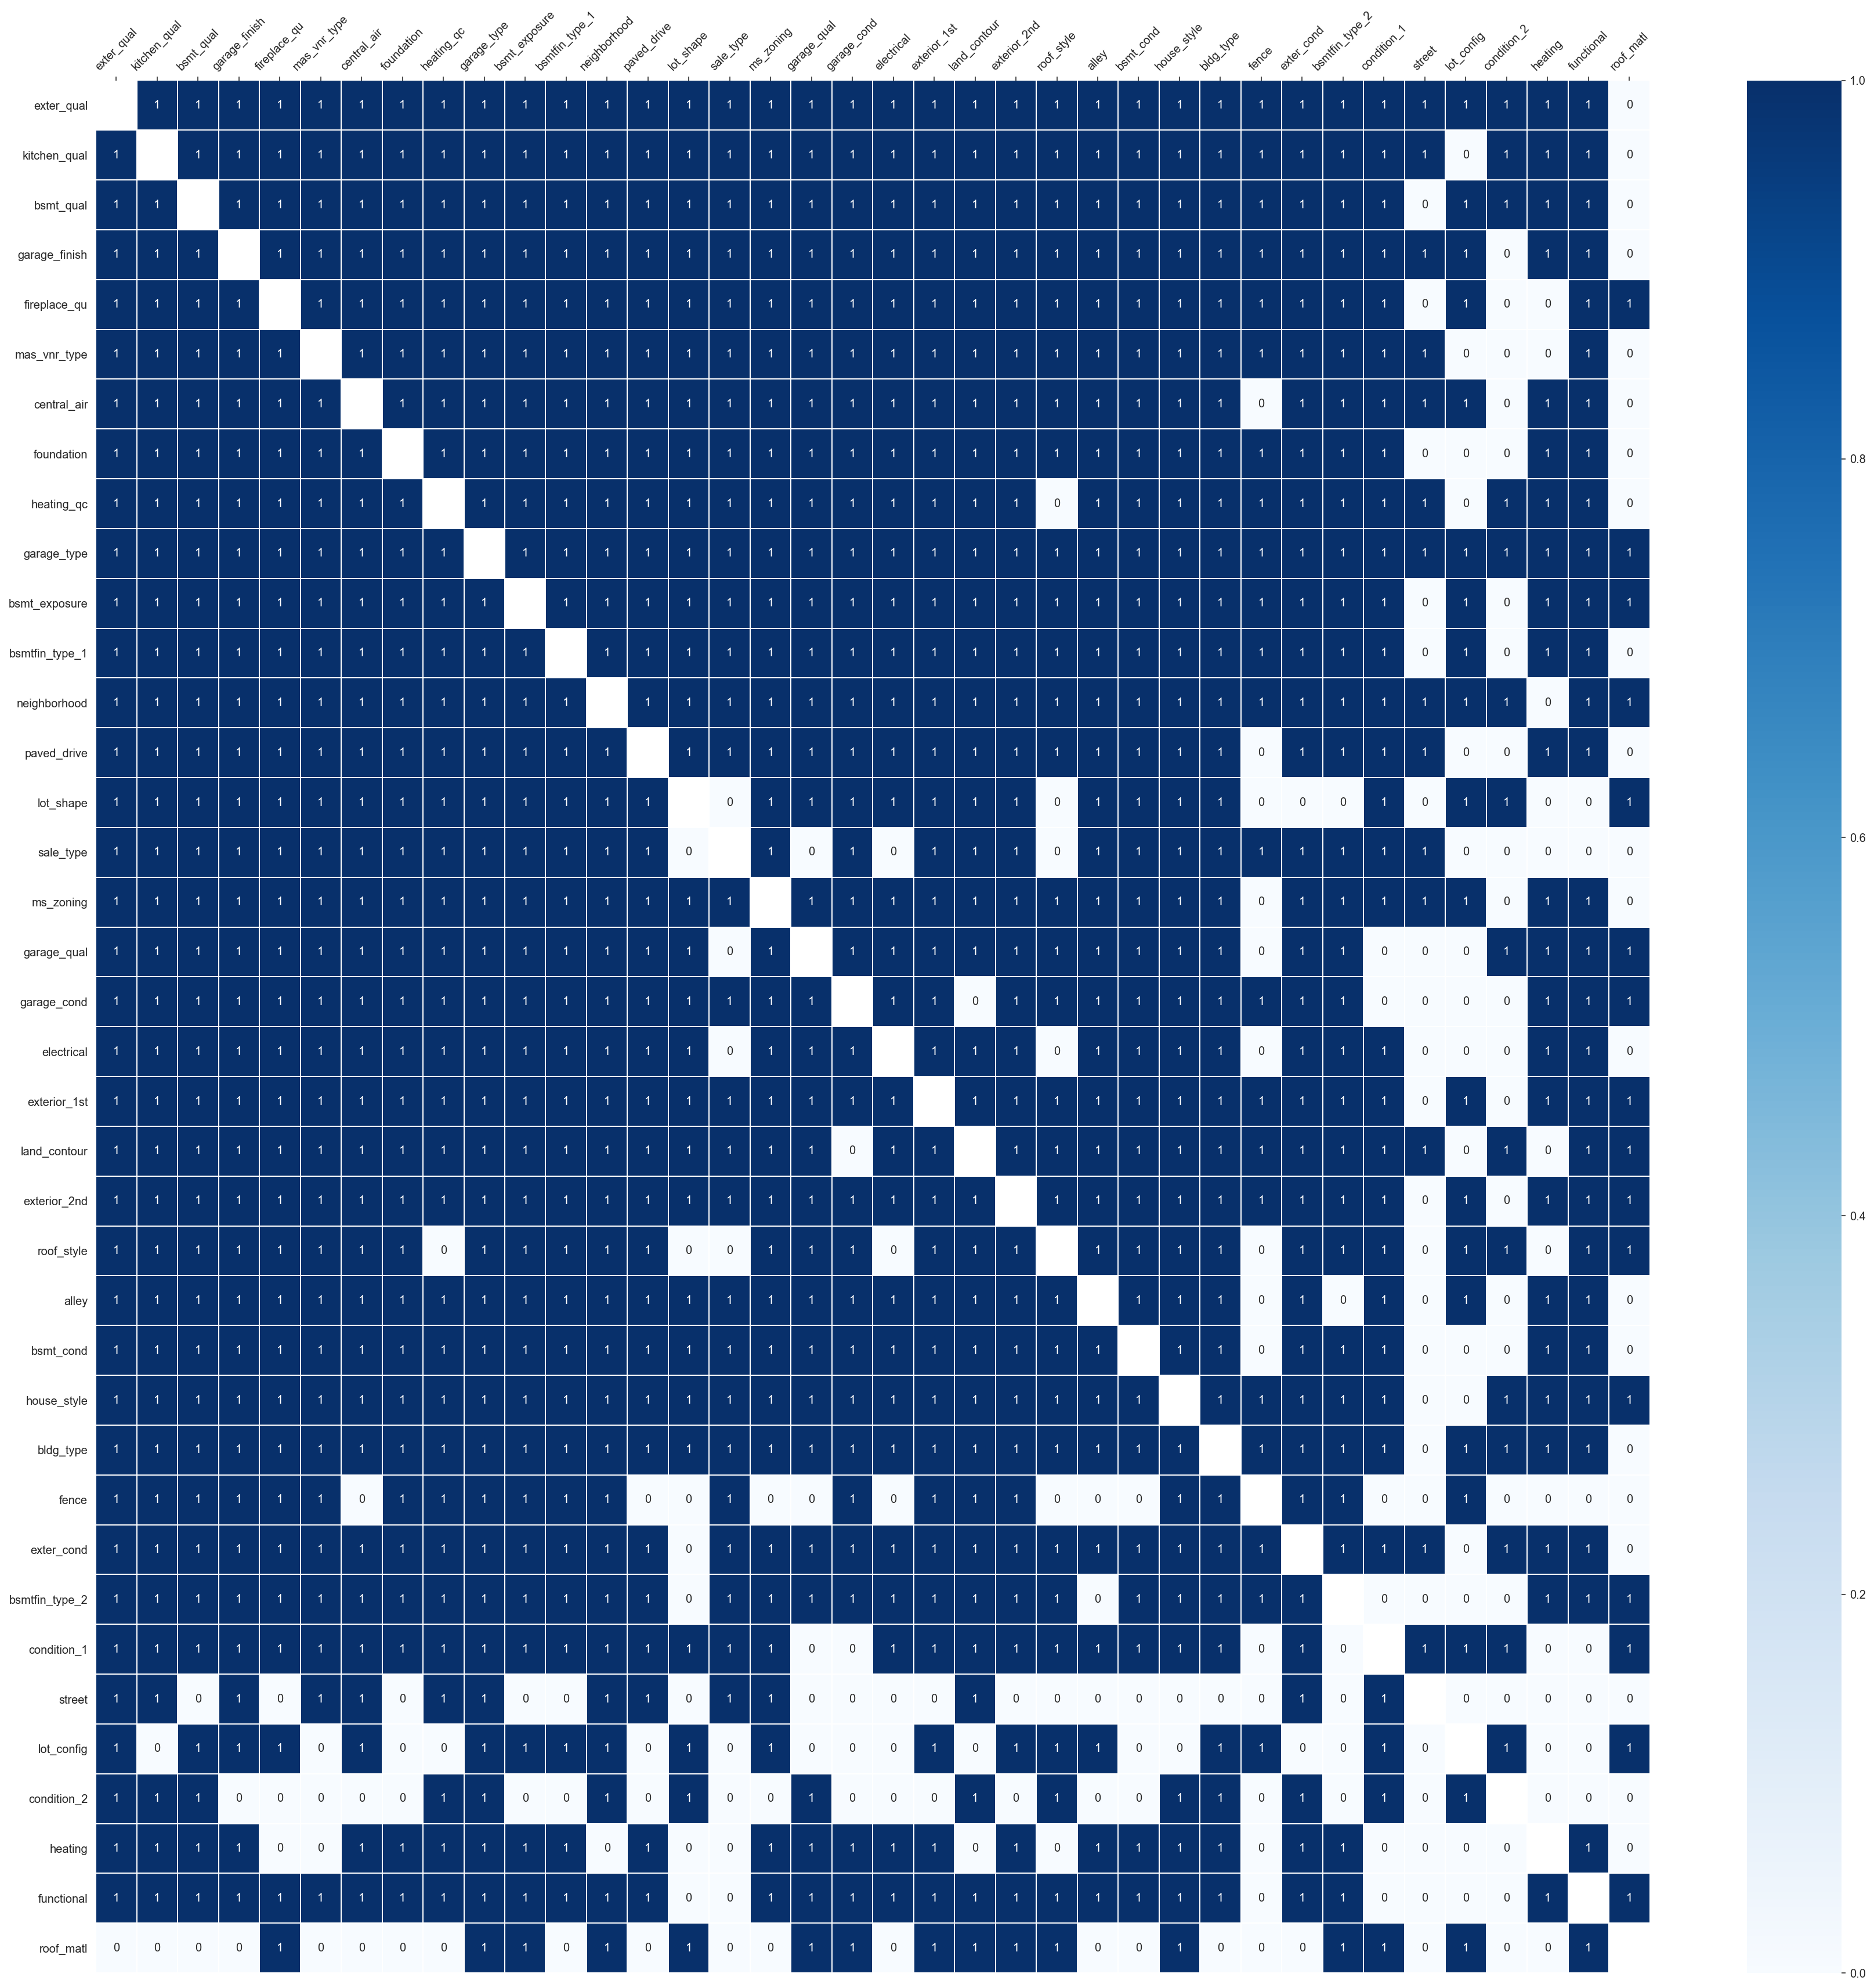

In [99]:
plt.figure(figsize = (30,30))
ax = sns.heatmap(chiPTable,xticklabels=True, yticklabels=True, annot=True,linewidths=.5, cmap="Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.xaxis.set_ticks_position('top')
plt.xticks(rotation=45);

In [100]:
chiPTableFiltered = chiPTable.copy()

If categories are correlated, drop the category with lower correlation to the target 'saleprice'

In [101]:
for prifeature in anovaFeaturesDf.index:
    if prifeature in chiPTableFiltered.index:
        for secFeature in chiPTableFiltered.index:
            if chiPTableFiltered.loc[prifeature,secFeature]==1:
                chiPTableFiltered.drop(columns=secFeature,axis=1,inplace=True)
                chiPTableFiltered.drop(secFeature,inplace=True)

In [102]:
amesChi2CatDf = amesDroppedOutliers.copy()
amesChi2CatDf = pd.DataFrame(amesChi2CatDf[chiPTableFiltered.index])
amesChi2CatDf.head()

exter_qual roof_matl
0         Gd   CompShg
1         Gd   CompShg
2         TA   CompShg
3         TA   CompShg
4         TA   CompShg

**Create Dummy Variables**

In [103]:
amesWithDummyX = pd.DataFrame()

In [104]:
for column in amesChi2CatDf.columns:
    dummyDf = pd.get_dummies(amesChi2CatDf[column],drop_first=True)
    dummyDf.columns = [(str(x)+'_'+str(column)) for x in dummyDf.columns]
    amesWithDummyX = pd.concat([amesWithDummyX,dummyDf],axis=1)

In [105]:
amesWithDummyX.head()

Fa_exter_qual  Gd_exter_qual  TA_exter_qual  Membran_roof_matl  \
0              0              1              0                  0   
1              0              1              0                  0   
2              0              0              1                  0   
3              0              0              1                  0   
4              0              0              1                  0   

   Tar&Grv_roof_matl  WdShake_roof_matl  WdShngl_roof_matl  
0                  0                  0                  0  
1                  0                  0                  0  
2                  0                  0                  0  
3                  0                  0                  0  
4                  0                  0                  0

In [106]:
amesWithDummyX.shape

(2028, 7)

### Model 5

Start with all the features and remove the feature with highest p-value at each iteration, to improve the performance of the model. We repeat this until all features selected have p-value < 0.05.

In [107]:
amesWithDummyXandContV = pd.concat([amesWithDummyX,xVIF],axis=1)
amesWithDummyXandContV.head()

Fa_exter_qual  Gd_exter_qual  TA_exter_qual  Membran_roof_matl  \
0              0              1              0                  0   
1              0              1              0                  0   
2              0              0              1                  0   
3              0              0              1                  0   
4              0              0              1                  0   

   Tar&Grv_roof_matl  WdShake_roof_matl  WdShngl_roof_matl  lot_area  \
0                  0                  0                  0  0.512071   
1                  0                  0                  0  0.211664   
2                  0                  0                  0 -0.317944   
3                  0                  0                  0 -0.039047   
4                  0                  0                  0  0.618586   

   mas_vnr_area  fireplaces  year_remod/add  full_bath  year_built  \
0      1.092329   -0.925701        0.989479   0.769779    0.142227   
1      0.191491    0.640811        0.609090   0.769779    0.805126   
2     -0.565901   -0.925701        1.084576  -1.051232   -0.620106   
3     -0.565901   -0.925701        1.084576   0.769779    1.136575   
4     -0.565901   -0.925701        0.418896   0.769779   -2.376787   

   totrms_abvgrd  overall_qual  total_sf  
0      -0.279441     -0.078644 -0.318677  
1       1.002738      0.622656  0.760424  
2      -0.920531     -0.779944 -0.816776  
3       0.361648     -0.779944 -0.610877  
4      -0.279441     -0.078644 -0.381874

In [108]:
model5 = linearRegression(sm.add_constant(amesWithDummyXandContV.values), amesY)
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     880.3
Date:                Thu, 19 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:28:15   Log-Likelihood:                -23601.
No. Observations:                2028   AIC:                         4.724e+04
Df Residuals:                    2011   BIC:                         4.733e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.517e+05   3773.070     66.711      0.000    2.44e+05    2.59e+05
x1         -7.461e+04   7223.086    -10.330      0.000   -8.88e+04   -6.04e+04
x2         -6.498e+04   3645.223    -17.826      0.000   -7.21e+04   -5.78e+04
x3         -7.585e+04   4162.360    -18.223      0.000    -8.4e+04   -6.77e+04
x4         -1.208e+04   2.81e+04     -0.430      0.667   -6.72e+04     4.3e+04
x5         -1.479e+04   7711.885     -1.918      0.055   -2.99e+04     331.127
x6         -4751.6096   1.39e+04     -0.343      0.732   -3.19e+04    2.24e+04
x7          2.768e+04   1.62e+04      1.712      0.087   -4033.572    5.94e+04
x8          1.204e+04   1160.227     10.378      0.000    9765.557    1.43e+04
x9          6051.3931    804.676      7.520      0.000    4473.308    7629.478
x10         4586.1676    726.806      6.310      0.000    3160.795    6011.540
x11         6185.4314    883.118      7.004      0.000    4453.510    7917.352
x12        -3895.5629    883.528     -4.409      0.000   -5628.288   -2162.838
x13         8054.7777    916.875      8.785      0.000    6256.653    9852.903
x14        -3402.2235    958.362     -3.550      0.000   -5281.710   -1522.737
x15         1.866e+04   1141.037     16.350      0.000    1.64e+04    2.09e+04
x16         3.977e+04   1414.048     28.127      0.000     3.7e+04    4.25e+04
==============================================================================
Omnibus:                      508.205   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3574.286
Skew:                           0.991   Prob(JB):                         0.00
Kurtosis:                       9.195   Cond. No.                         91.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
p_values = pd.DataFrame(model5.summary2().tables[1]['P>|t|']).sort_values(by='P>|t|',ascending=False)

In [110]:
amesWithDummyXandContV_pValue = amesWithDummyXandContV.copy()

while ((p_values.iloc[0,0])>0.05):
    i=0
    if p_values.index[0]=='const':
        i=1
    indexName = p_values.index[i]
    indexToDrop = int(indexName.split('x')[1])-1
    print(p_values.iloc[i,0])
    amesWithDummyXandContV_pValue.drop(amesWithDummyXandContV_pValue.columns[indexToDrop],axis=1,inplace=True)
    model5 = linearRegression(sm.add_constant(amesWithDummyXandContV_pValue.values), amesY)
    p_values = pd.DataFrame(model5.summary2().tables[1]['P>|t|']).sort_values(by='P>|t|',ascending=False)
    print('dropped')

0.7316213853957902
dropped
0.666815235738949
dropped
0.08494216021540722
dropped
0.05459136556095911
dropped


In [111]:
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1171.
Date:                Thu, 19 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:28:16   Log-Likelihood:                -23605.
No. Observations:                2028   AIC:                         4.724e+04
Df Residuals:                    2015   BIC:                         4.731e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.518e+05   3773.478     66.729      0.000    2.44e+05    2.59e+05
x1         -7.482e+04   7223.866    -10.357      0.000    -8.9e+04   -6.07e+04
x2         -6.499e+04   3641.607    -17.847      0.000   -7.21e+04   -5.78e+04
x3         -7.613e+04   4159.418    -18.303      0.000   -8.43e+04    -6.8e+04
x4          1.187e+04   1139.054     10.420      0.000    9635.556    1.41e+04
x5          5940.9279    802.959      7.399      0.000    4366.212    7515.644
x6          4549.7336    726.758      6.260      0.000    3124.458    5975.009
x7          6199.3354    881.559      7.032      0.000    4470.473    7928.197
x8         -4061.0819    880.729     -4.611      0.000   -5788.316   -2333.848
x9          7995.6225    915.798      8.731      0.000    6199.612    9791.633
x10        -3324.0659    957.684     -3.471      0.001   -5202.220   -1445.911
x11         1.864e+04   1136.646     16.400      0.000    1.64e+04    2.09e+04
x12         3.997e+04   1408.487     28.375      0.000    3.72e+04    4.27e+04
==============================================================================
Omnibus:                      511.827   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3644.533
Skew:                           0.995   Prob(JB):                         0.00
Kurtosis:                       9.258   Cond. No.                         28.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 5 Validation

**Cross Validation**

In [112]:
lr = LinearRegression()
scores = cross_val_score(lr, amesWithDummyXandContV_pValue.values, amesY, cv=5)
print(scores.mean())
print(scores.std())
print(scores)

0.8727631702248022
0.011874832048635263
[0.8676266  0.89347085 0.86575868 0.87753827 0.85942146]


In [113]:
amesWithDummyXandContV_pValue.columns

Index(['Fa_exter_qual', 'Gd_exter_qual', 'TA_exter_qual', 'lot_area',
       'mas_vnr_area', 'fireplaces', 'year_remod/add', 'full_bath',
       'year_built', 'totrms_abvgrd', 'overall_qual', 'total_sf'],
      dtype='object')

In [114]:
amesWithDummyXandContV_pValue.shape

(2028, 12)

**Train Test Split**

In [115]:
model5_x80 = amesWithDummyXandContV_pValue.values
model5_xTrain80, model5_xTest80, model5_yTrain80, model5_yTest80 = train_test_split(model5_x80, amesY, 
                                                                                    train_size=0.8,random_state=42)
model5_80 = LinearRegression().fit(model5_xTrain80,model5_yTrain80)
print(model5_80.coef_)
print(model5_80.intercept_)

[-80285.36026694 -70014.03645384 -80033.5347887   12062.54225103
   5212.18649401   5088.10971965   6563.24043947  -3864.45761429
   7391.7438704   -3891.28274082  18228.11344781  40459.17419139]
256114.88029710588


In [116]:
model5_80.score(model5_xTrain80,model5_yTrain80)

0.8743437790606602

In [117]:
model5_80.score(model5_xTest80,model5_yTest80)

0.8736029404395005

In [118]:
rmse = np.sqrt(mean_squared_error(model5_yTest80,model5_80.predict(model5_xTest80)))
print(rmse)

30012.96653596731


### Model 6

**Regularisation**

In [119]:
r_alphas = np.logspace(0, 5, 200)
ridge = RidgeCV(alphas=r_alphas).fit(amesWithDummyXandContV_pValue.values, amesY)
bestRidgeAlpha = ridge.alpha_
ridgeOptimal = RidgeCV(alphas=[bestRidgeAlpha],cv=5).fit(amesWithDummyXandContV_pValue.values, amesY)
ridgeOptimal.score(amesWithDummyXandContV_pValue.values, amesY)

0.8745423212773012

In [120]:
bestRidgeAlpha

1.0

In [121]:
ridgeOptimal.coef_

array([-67311.51249621, -61418.50843408, -71786.14920069,  11896.25326703,
         6092.43873439,   4535.60662283,   6325.34123024,  -4097.81793373,
         8044.19576577,  -3307.83583905,  19078.22251555,  39964.11356647])

In [122]:
lasso = LassoCV(n_alphas=100,cv=5).fit(amesWithDummyXandContV_pValue.values, amesY)
bestLassoAlpha = lasso.alpha_
lassoOptimal = LassoCV(alphas=[bestLassoAlpha],cv=5).fit(amesWithDummyXandContV_pValue.values, amesY)
lassoOptimal.score(amesWithDummyXandContV_pValue.values, amesY)

0.8743439176116053

In [123]:
elasticNet = ElasticNetCV(n_alphas=100,cv=5,l1_ratio=[.1, .5, .7, .9, .95, .99, 1]).fit(amesWithDummyXandContV_pValue.values, 
                                                                                        amesY)
bestElasticAlpha = elasticNet.alpha_
bestElasticRatio = elasticNet.l1_ratio_
elasticOptimal = ElasticNetCV(alphas=[bestElasticAlpha],l1_ratio=bestElasticRatio, 
                              cv=5).fit(amesWithDummyXandContV_pValue.values, amesY)
elasticOptimal.score(amesWithDummyXandContV_pValue.values, amesY)

0.8743439176116053

Ridge regularisation selected as model since it has the best R2 score.

In [124]:
model6 = Ridge(alpha=bestRidgeAlpha)

### Model 6 Validation

**Train Test Split**

In [125]:
model6_x80 = amesWithDummyXandContV_pValue.values
model6_xTrain80, model6_xTest80, model6_yTrain80, model6_yTest80 = train_test_split(model6_x80, amesY, 
                                                                                    train_size=0.8,random_state=42)
model6_80 = model6.fit(model6_xTrain80,model6_yTrain80)
print(model6_80.coef_)
print(model6_80.intercept_)

[-69794.162004   -64644.99077242 -73657.19383131  12081.66041149
   5427.20485719   5073.9451849    6707.52089332  -3917.71193901
   7462.92189988  -3865.99009148  18821.17729593  40450.76369754]
250260.287447582


In [126]:
model6_80.score(model6_xTrain80,model6_yTrain80)

0.8741784699750961

In [127]:
model6_80.score(model6_xTest80,model6_yTest80)

0.8743914203491207

This R2 score is significantly better than the baseline model. A constant model that always predicts the expected value of 'saleprice', disregarding the input features, would get a R2 score of 0.0.

In [128]:
rmse = np.sqrt(mean_squared_error(model6_yTest80,model6_80.predict(model6_xTest80)))
print(rmse)

29919.207858087044


### Model 5 and 6 Predictions on Kaggle Test Set

In [129]:
testSetXScaledWithDummies = pd.DataFrame()

for column in amesChi2CatDf.columns:
    dummyDf = pd.get_dummies(testSet[column],drop_first=True)
    dummyDf.columns = [(x+'_'+column) for x in dummyDf.columns]
    testSetXScaledWithDummies = pd.concat([testSetXScaledWithDummies,dummyDf],axis=1)

In [130]:
testSetXScaledWithDummies.head()

Fa_exter_qual  Gd_exter_qual  TA_exter_qual  Metal_roof_matl  \
0              0              0              1                0   
1              0              0              1                0   
2              0              1              0                0   
3              0              1              0                0   
4              0              0              1                0   

   Roll_roof_matl  Tar&Grv_roof_matl  WdShake_roof_matl  WdShngl_roof_matl  
0               0                  0                  0                  0  
1               0                  0                  0                  0  
2               0                  0                  0                  0  
3               0                  0                  0                  0  
4               0                  0                  0                  0

In [131]:
testSetXScaledWithDummies.shape

(879, 8)

In [132]:
testSetXScaledWithDummiesAll = pd.concat([testSetXScaledWithDummies,testSetXScaled],axis=1)
testSetXScaledWithDummiesAll.head()

Fa_exter_qual  Gd_exter_qual  TA_exter_qual  Metal_roof_matl  \
0              0              0              1                0   
1              0              0              1                0   
2              0              1              0                0   
3              0              1              0                0   
4              0              0              1                0   

   Roll_roof_matl  Tar&Grv_roof_matl  WdShake_roof_matl  WdShngl_roof_matl  \
0               0                  0                  0                  0   
1               0                  0                  0                  0   
2               0                  0                  0                  0   
3               0                  0                  0                  0   
4               0                  0                  0                  0   

   lot_area  mas_vnr_area  fireplaces  year_remod/add  full_bath  year_built  \
0 -0.136957     -0.565901   -0.925701       -1.625693   0.769779   -2.045338   
1 -0.059816     -0.565901   -0.925701       -0.341881   0.769779    0.175372   
2  1.044200     -0.565901    0.640811        1.037027   0.769779    1.136575   
3 -0.229231     -0.565901   -0.925701        1.037027  -1.051232   -1.614454   
4 -0.083848      0.851340    2.207324       -1.007562  -1.051232   -0.288657   

   totrms_abvgrd  overall_qual  total_sf  
0       1.643827     -0.078644  0.479097  
1       2.284917     -0.779944  1.345504  
2       0.361648      0.622656 -0.322754  
3      -0.920531     -0.779944 -0.874537  
4      -0.279441     -0.078644  0.068658

In [133]:
trainedCols = amesWithDummyXandContV_pValue.columns

In [134]:
testSetXScaledWithDummiesFiltered = testSetXScaledWithDummiesAll[trainedCols]
testSetXScaledWithDummiesFiltered.head()

Fa_exter_qual  Gd_exter_qual  TA_exter_qual  lot_area  mas_vnr_area  \
0              0              0              1 -0.136957     -0.565901   
1              0              0              1 -0.059816     -0.565901   
2              0              1              0  1.044200     -0.565901   
3              0              1              0 -0.229231     -0.565901   
4              0              0              1 -0.083848      0.851340   

   fireplaces  year_remod/add  full_bath  year_built  totrms_abvgrd  \
0   -0.925701       -1.625693   0.769779   -2.045338       1.643827   
1   -0.925701       -0.341881   0.769779    0.175372       2.284917   
2    0.640811        1.037027   0.769779    1.136575       0.361648   
3   -0.925701        1.037027  -1.051232   -1.614454      -0.920531   
4    2.207324       -1.007562  -1.051232   -0.288657      -0.279441   

   overall_qual  total_sf  
0     -0.078644  0.479097  
1     -0.779944  1.345504  
2      0.622656 -0.322754  
3     -0.779944 -0.874537  
4     -0.078644  0.068658

In [135]:
testSetXScaledWithDummiesFiltered.shape

(879, 12)

In [136]:
yhat5 = model5.predict(sm.add_constant(testSetXScaledWithDummiesFiltered))

In [137]:
model5Pred = pd.DataFrame()
model5Pred['ID'] = testSet['id']
model5Pred['SalePrice'] = yhat5

In [138]:
model5Pred = model5Pred.set_index('ID');

In [139]:
model5Pred.to_csv('../predictions/model5Pred.csv')

In [140]:
yhat6 = model6.predict(testSetXScaledWithDummiesFiltered)

In [141]:
model6Pred = pd.DataFrame()
model6Pred['ID'] = testSet['id']
model6Pred['SalePrice'] = yhat6

In [142]:
model6Pred = model6Pred.set_index('ID');

In [143]:
model6Pred.to_csv('../predictions/model6Pred.csv')

### Conclusions and Recommendations

Based on the Kaggle RMSE score, Model 6 performed the best in terms of the public score (33235). 

This implies that the model is able to predict Ames housing prices, with a root mean square error of about $33,235. 

The RMSE is about 18% of the mean housing saleprice ($181k).

In [144]:
dataDict = pd.DataFrame(amesWithDummyXandContV_pValue.dtypes, columns=['Type'])
dataDict['Description'] = ['External Material Quality: Fair',
                           'External Material Quality: Good','Exterior Material Quality: Average','Lot size in square feet',
                           'Masonry Veneer Area in square feet','Number of fireplaces',
                           'Remodel Date (same as data of construction if no remodelling or additions)',
                           'Full bathrooms above grade','Original construction date',
                           'Total rooms above grade (excluding bathrooms)','Overall material and finish quality',
                           'Total square feet area (basement,1st floor,2nd floor,wood deck,open porch,garage,gr liv area)']

In [145]:
dataDict.to_csv('../data dictionary/dataDict_selectedFeatures_Model6.csv')

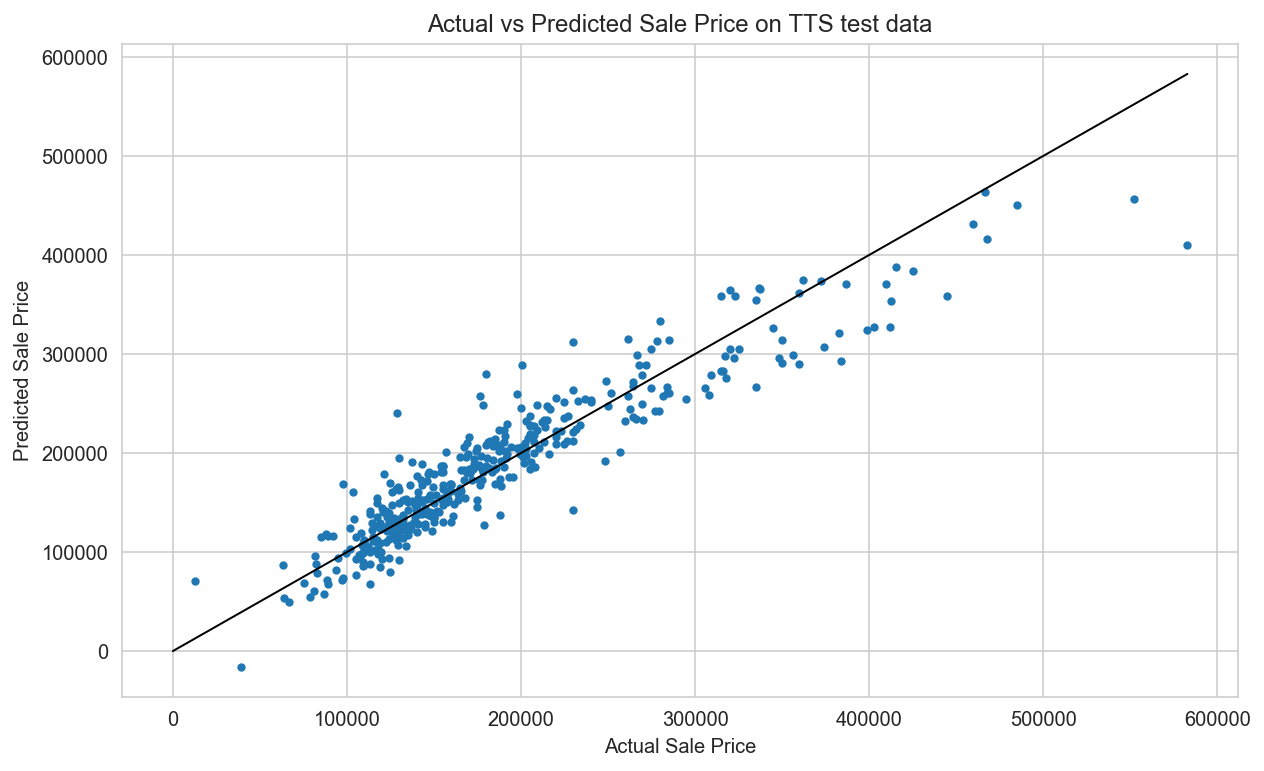

In [146]:
plt.figure(figsize=(10,6))
plt.scatter(model6_yTest80, model6_80.predict(model6_xTest80),s=10)
plt.plot([0, np.max(model6_yTest80)], [0, np.max(model6_yTest80)],c='k',linewidth=1)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Price on TTS test data');

**Key Challenges**
1. Many features provided but most are highly correlated to each other
2. Limitations of using Linear Regression Model - assumptions of linearity, normality may not hold true based on EDA

**Recommendations**
1. Explore other more sophisticated models e.g. random forest